Clustering analysis

In [325]:
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [326]:
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Combined_data_new.csv'
df=pd.read_csv(url,index_col='FIPS',encoding="ISO-8859-1")

In [327]:
#standardize data: (x-mean(x))/std
from sklearn import preprocessing
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 1001 to 56045
Data columns (total 61 columns):
var57                                0 non-null float64
var68                                3139 non-null float64
var44                                3137 non-null float64
var60                                3143 non-null float64
var14                                3143 non-null float64
var13                                3124 non-null float64
var39                                3143 non-null float64
var9                                 3124 non-null float64
var67                                3139 non-null float64
var3                                 3140 non-null float64
var40                                3143 non-null float64
var23                                3143 non-null float64
var8                                 3124 non-null float64
var18                                3141 non-null float64
var2                                 3123 non-null float64
var65  

In [334]:
#read in variable information and build variable information dictionary with variable names as key
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Food_atlas/Var_name_info.csv'
var_info_df=pd.read_csv(url,encoding="ISO-8859-1", index_col='var_name')

In [335]:
df_no_region=df[df.columns.difference(['Region', 'Division','State', 'County', 'RUCC_2013'])]

In [336]:
df_dropnacol=df_no_region.dropna(axis=1)

In [337]:
df_dropnacol.shape

(3143, 31)

In [403]:
#remove state level stats
df_dropnacol=df_dropnacol.drop(['var'+str(n) for n in [21,22,23,24,27,30,31,32,33,34,35,36,37,38,39]], axis=1)

build pipeline for hierachical clustering: scaler to clustering

In [404]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(df_dropnacol.values)
normed_df=pd.DataFrame(X_minmax, index=df_dropnacol.index, columns=df_dropnacol.columns)

#normed_data=preprocessing.scale(df_dropnacol)
#normed_df=pd.DataFrame(normed_data, index=df_dropnacol.index, columns=df_dropnacol.columns)

PCA

In [405]:
#PCA using Sklearn 
from sklearn.decomposition import PCA

explained_var=list()
for d in range(1,len(normed_df.columns)):
    pca = PCA(n_components=d)
    pca.fit(normed_df)
    explained_var.append(sum(pca.explained_variance_ratio_))

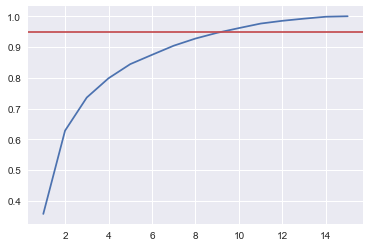

In [406]:
plt.plot(range(1,len(normed_df.columns)), explained_var)
plt.axhline(y=0.95, color='r')
plt.show()

In [407]:
#95% of variance can be explained by 9 components out of total 15 variables
pca = PCA(n_components=9)
pca.fit(normed_df)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [408]:
data_transformed=pca.transform(normed_df)
df_transformed=pd.DataFrame(data_transformed, index=normed_df.index)

Hierachical clustering

In [409]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

X=df_transformed
distance_way= ['ward', 'single', 'average', 'weighted', 'centroid', 'median']

for m in distance_way:
    Z = linkage(X, m)
    c, coph_dists = cophenet(Z, pdist(X))
    print (m, c)

ward 0.759341802993
single 0.718790455879
average 0.846695667358
weighted 0.76950245652
centroid 0.858949637768
median 0.738634984738


both average method and centroid method is the best regarding the similarity between compuated distance to real distance

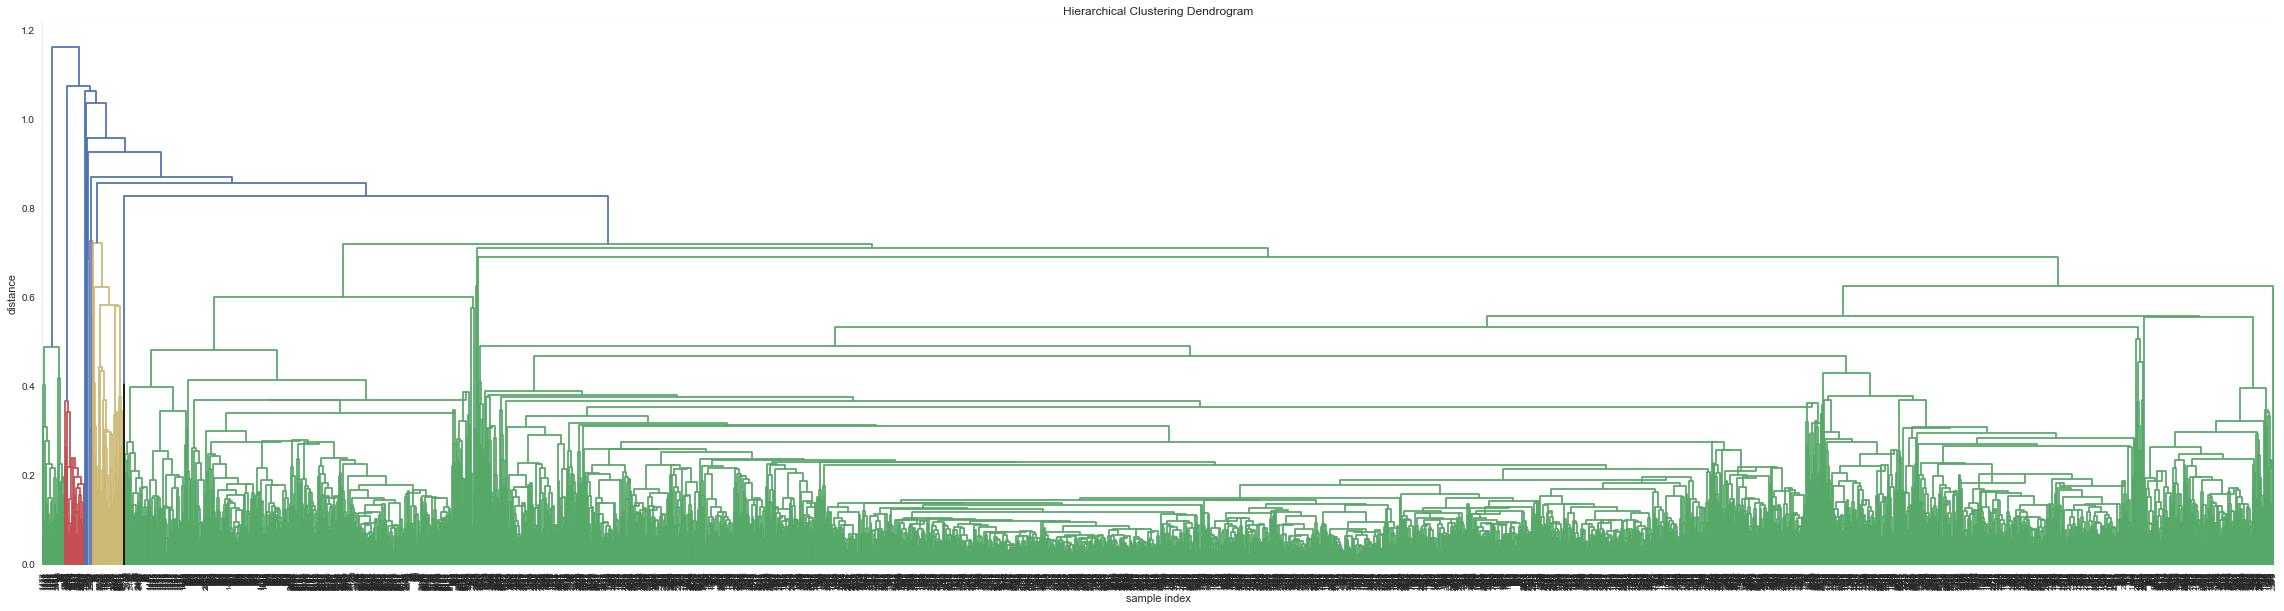

In [520]:
X=df_transformed
Z = linkage(X, 'centroid')
plt.figure(figsize=(40, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.show()

cut into several clusters to better understand each cluster

In [411]:
from scipy.cluster.hierarchy import cut_tree, fcluster
from collections import Counter

for distance in np.linspace(0.2, 0.8, 10):
    labels = fcluster(Z,distance,'distance')
    print (distance, max(Counter(labels).values()), max(labels))

0.2 1239 312
0.266666666667 1588 152
0.333333333333 1743 83
0.4 1883 45
0.466666666667 1883 35
0.533333333333 2334 30
0.6 2527 21
0.666666666667 2529 16
0.733333333333 3027 10
0.8 3027 10


In [521]:
labels = fcluster(Z,0.6,'distance')
Counter(labels)

Counter({1: 31,
         2: 29,
         3: 2,
         4: 2,
         5: 2,
         6: 2,
         7: 7,
         8: 35,
         9: 1,
         10: 2,
         11: 487,
         12: 8,
         13: 1,
         14: 1,
         15: 2527,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1})

In [522]:
groups_to_plot=[l for l in Counter(labels).keys() if Counter(labels)[l]>10]

In [523]:
groups_to_plot

[11, 1, 15, 8, 2]

In [434]:
sum([v for v in Counter(labels).values() if v>=60])

3014

In [524]:
df['group']=labels

In [422]:
def Box_plot_by_var(features, data, by, order):
    n=1
    for c in features:
        if is_numeric_dtype(data[c]):
            if order==None:
                sns.boxplot(x=by, y=c, data=data)
            else:
                sns.boxplot(x=by, y=c, data=data, order=order)
            if c in var_info_df.index:
                plt.ylabel(str(var_info_df.loc[c]['Category Name'])+'\n'+str(var_info_df.loc[c]['Sub_subcategory Name']))            
            else: 
                plt.ylabel(c)
            plt.title(c)
            plt.legend()
            plt.show()
            n+=1

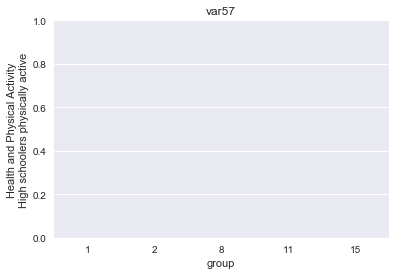

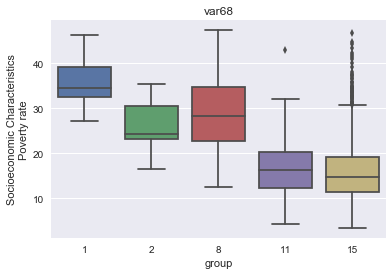

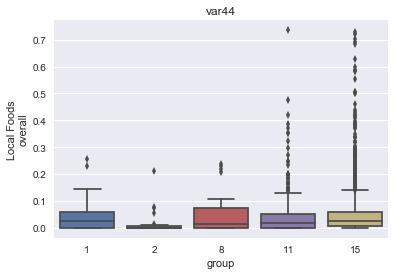

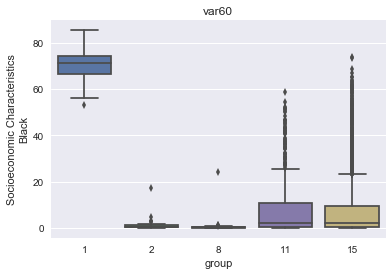

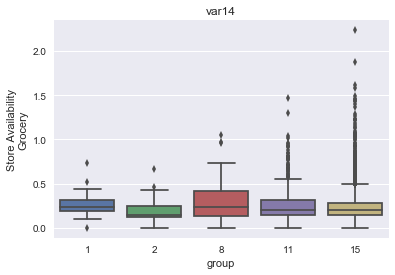

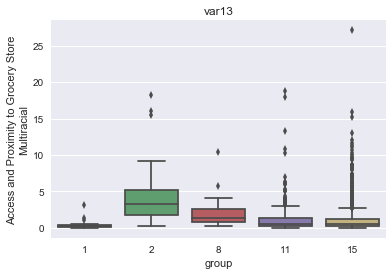

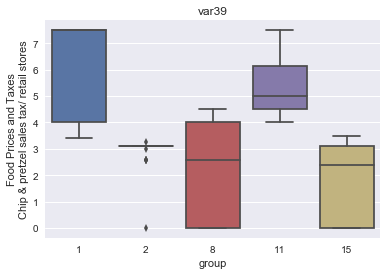

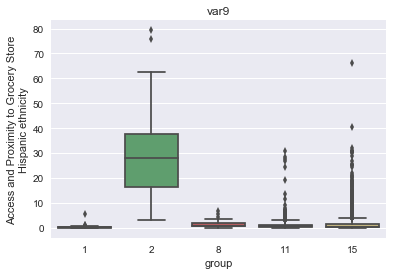

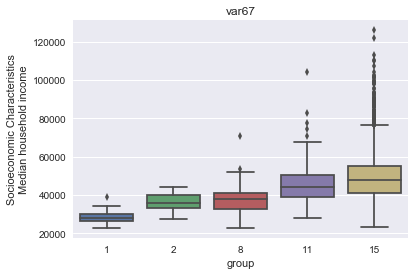

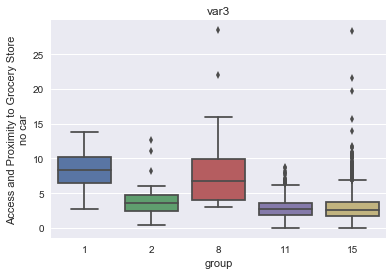

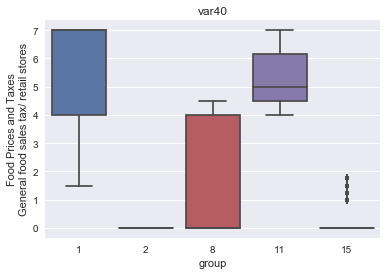

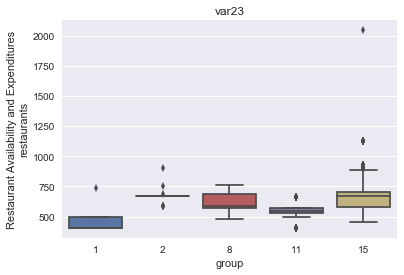

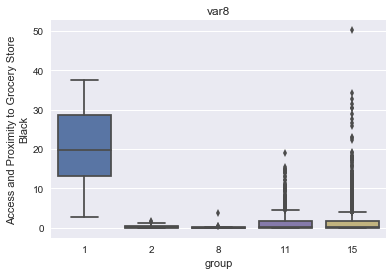

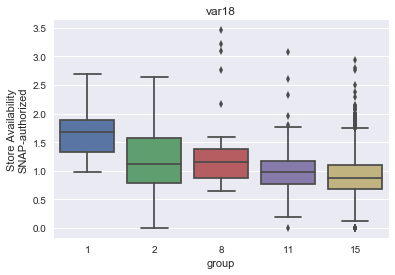

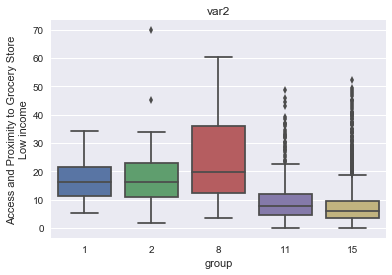

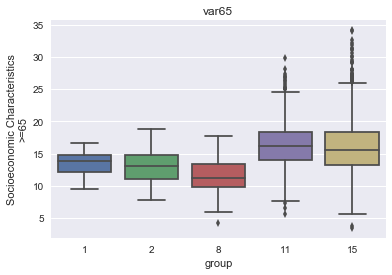

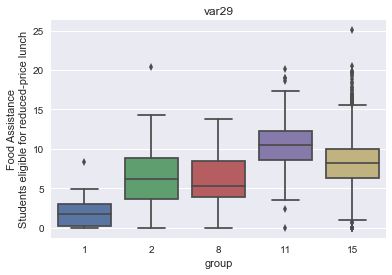

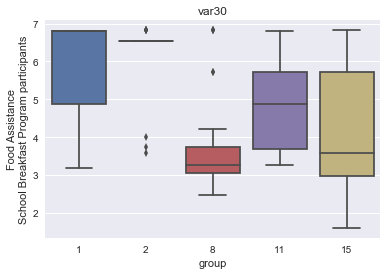

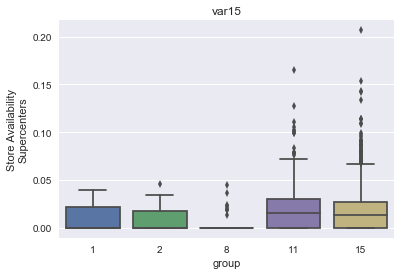

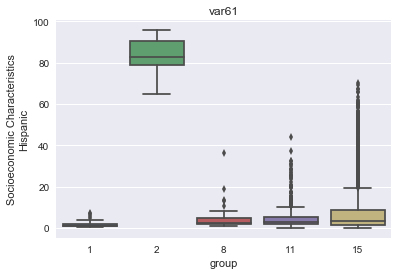

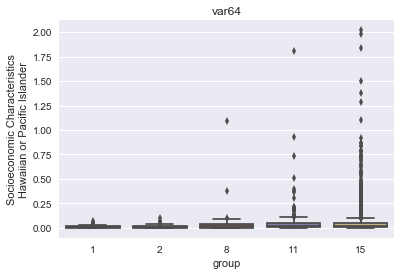

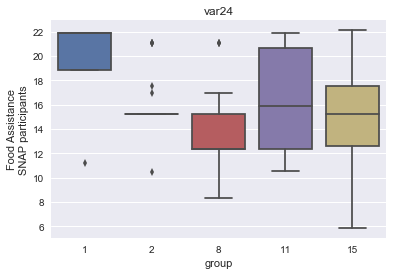

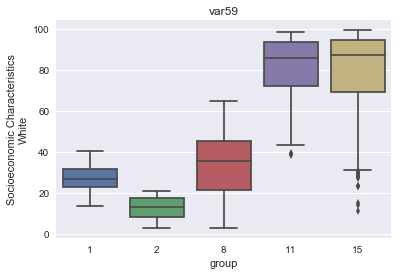

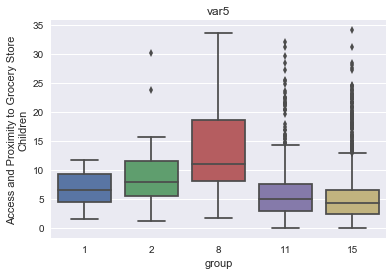

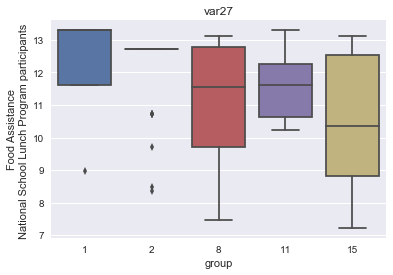

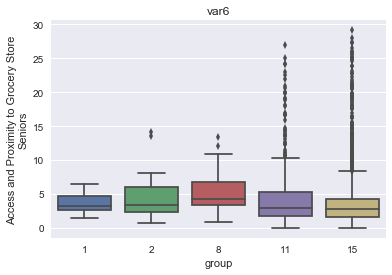

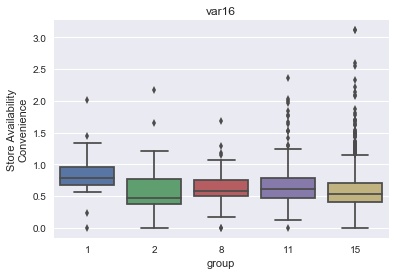

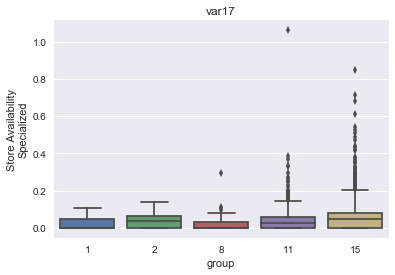

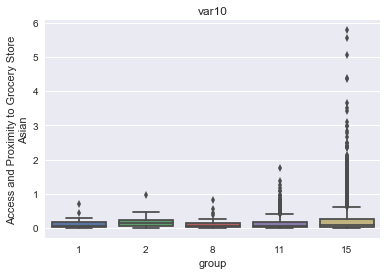

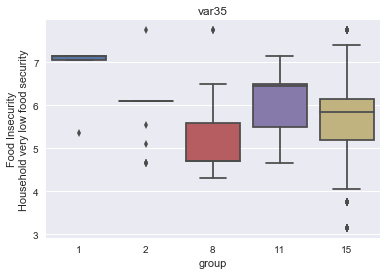

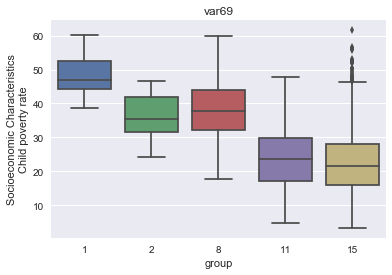

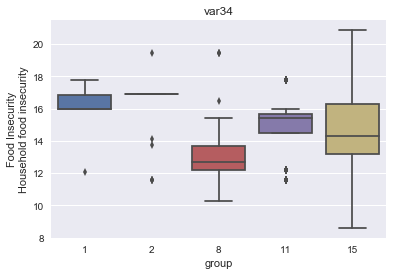

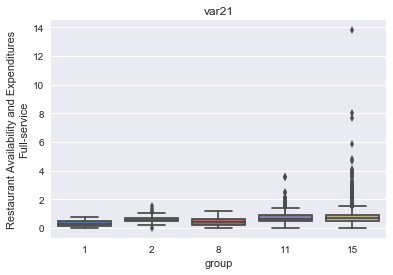

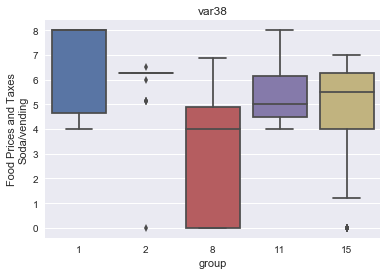

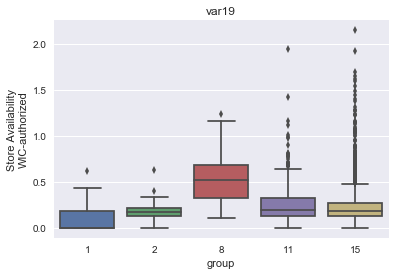

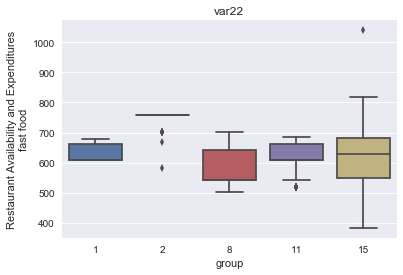

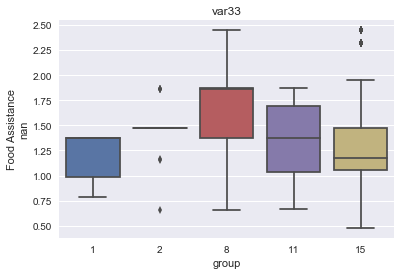

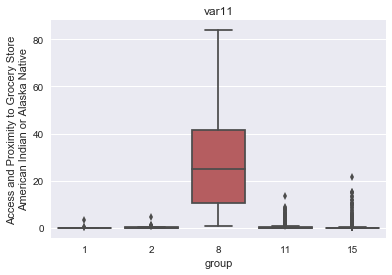

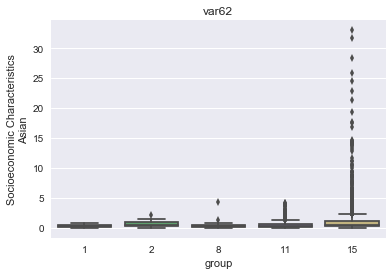

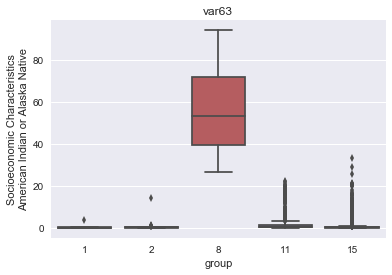

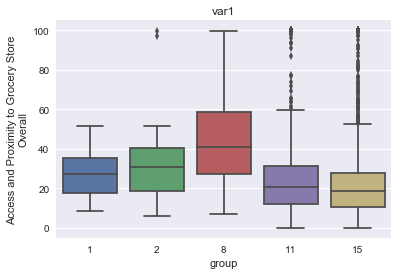

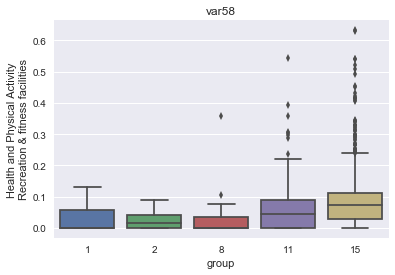

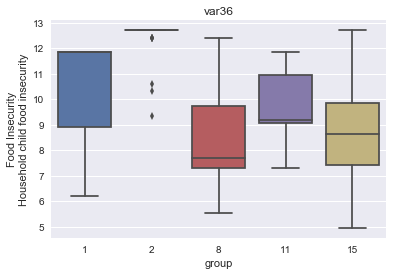

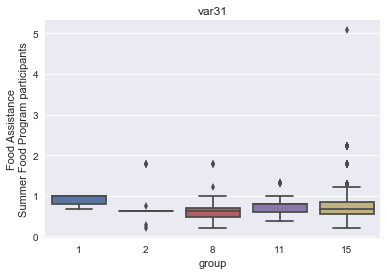

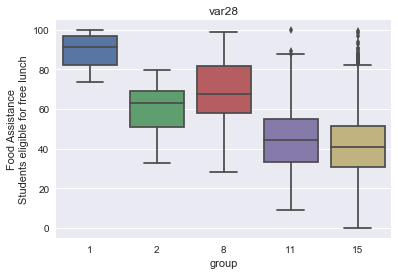

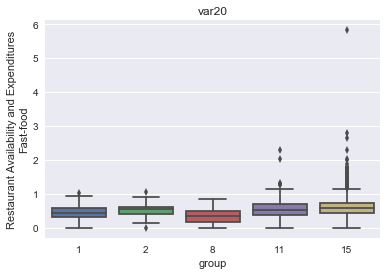

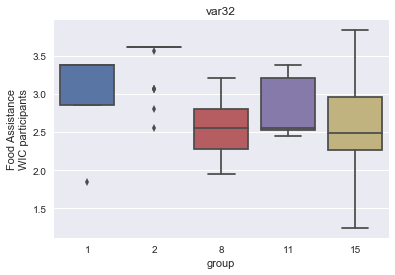

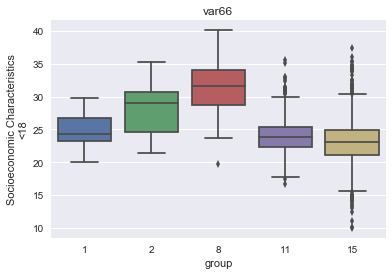

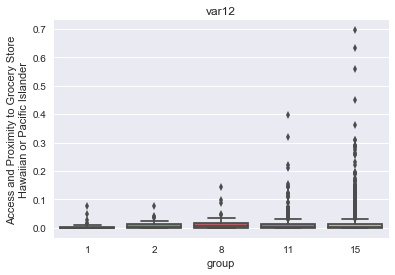

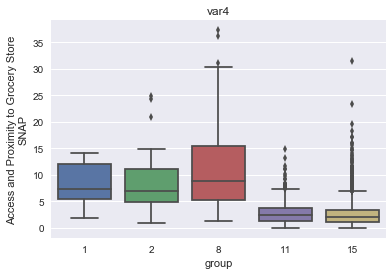

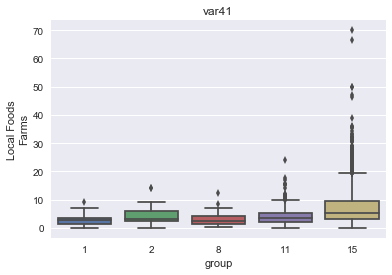

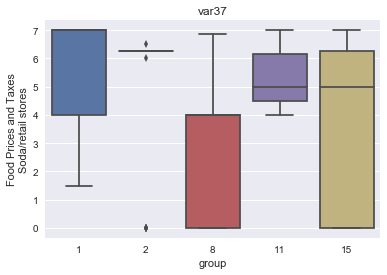

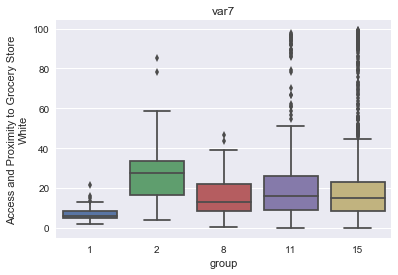

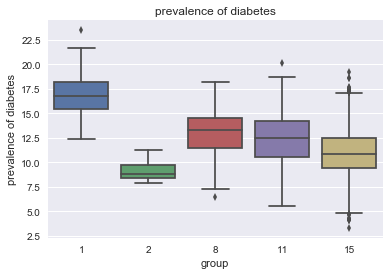

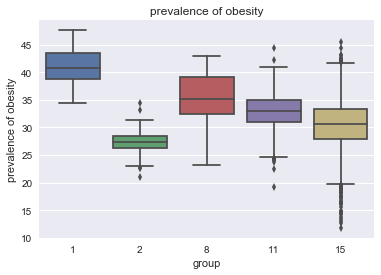

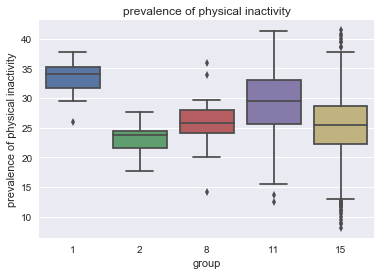

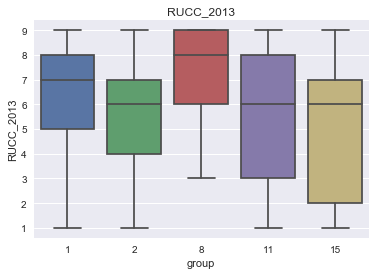

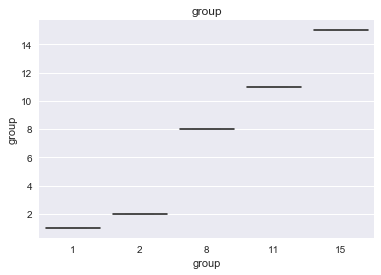

In [436]:
#colors=['b','g','y','r', 'orange','m', 'purple']

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype


features=df.columns
data=df[df['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=None)

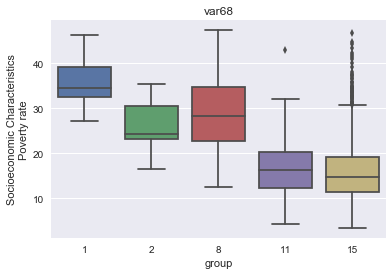

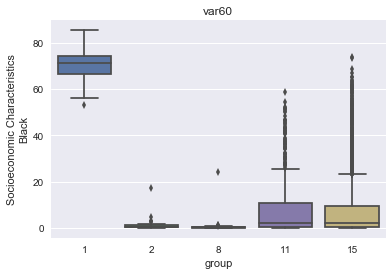

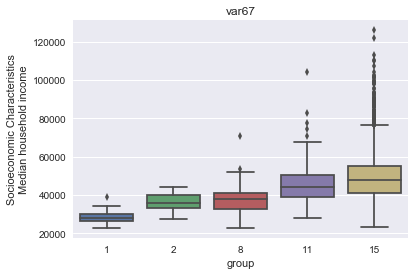

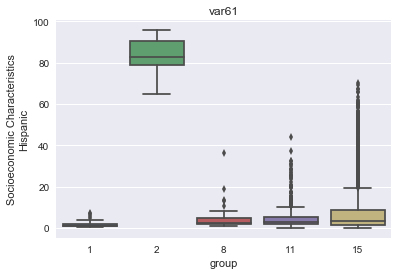

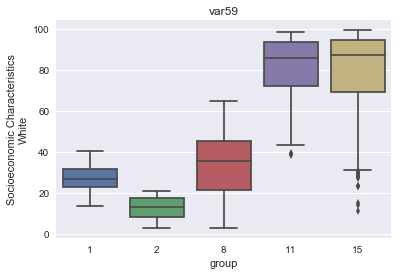

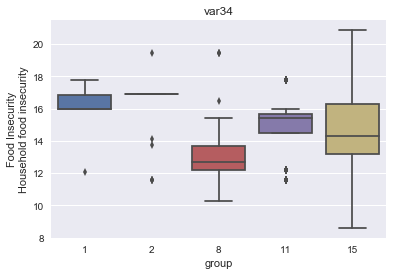

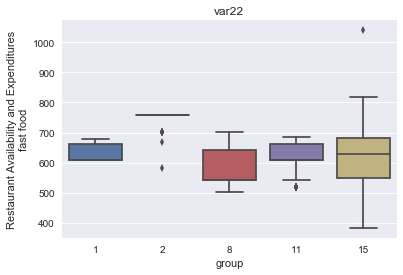

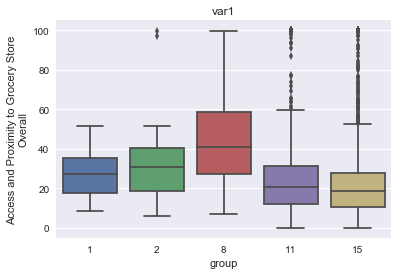

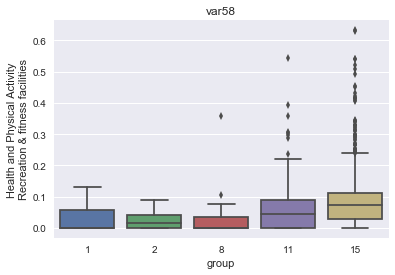

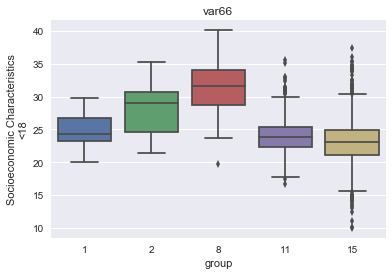

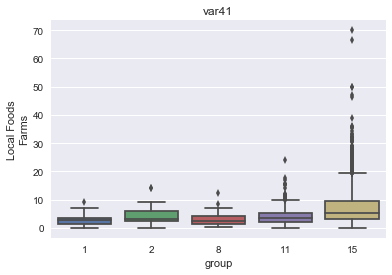

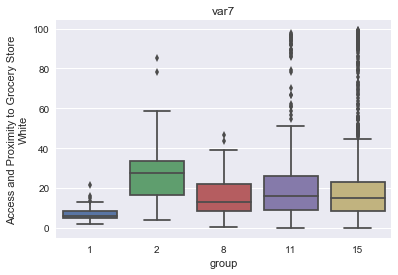

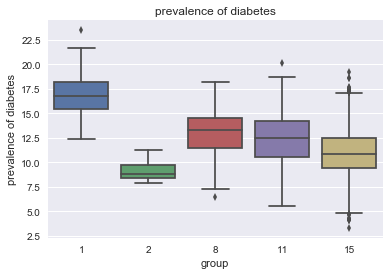

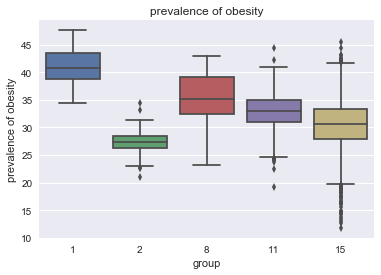

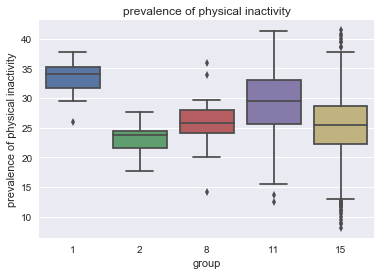

In [437]:
features=['var'+str(i) for i in [68, 60, 67, 61, 59, 34, 22, 1, 58, 66, 41, 7]]
features.extend(['prevalence of diabetes','prevalence of obesity','prevalence of physical inactivity'])
data=df[df['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=None)

In [363]:
race_var_list=list()
for v in var_info_df.index:
    if var_info_df.loc[v]['Category Code']=='SOCIOECONOMIC' and var_info_df.loc[v]['Subcategory Name']=='Race':
        race_var_list.append((var_info_df.loc[v]['Sub_subcategory Name'], v))
print (race_var_list)

[('White', 'var59'), ('Black', 'var60'), ('Hispanic', 'var61'), ('Asian', 'var62'), ('American Indian or Alaska Native', 'var63'), ('Hawaiian or Pacific Islander', 'var64')]


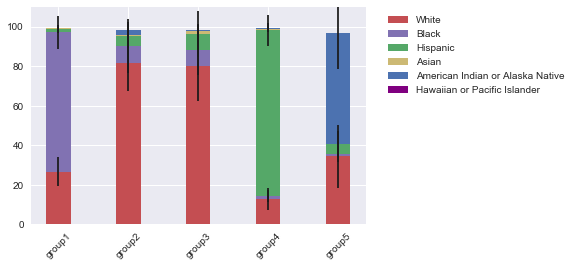

In [451]:
#stacked percentage plot with standard deviation

import numpy as np
import matplotlib.pyplot as plt

N=5


whitemeans=np.empty(N)
whitestd=np.empty(N)
blackmeans=np.empty(N)
blackstd=np.empty(N)
asianmeans=np.empty(N)
asianstd=np.empty(N)
hispmeans=np.empty(N)
hispstd=np.empty(N)
Ame_Ind_Alkmeans=np.empty(N)
Ame_Ind_Alkstd=np.empty(N)
Hawa_Islandmeans=np.empty(N)
Hawa_Islandstd=np.empty(N)

groups=[1,11,15,2,8]

for n, group in enumerate(groups):
    df_group=df[df['group']==group]
    whitemeans[n]=np.mean(df_group['var59'])
    whitestd[n]=np.std(df_group['var59'])
    
    blackmeans[n]=np.mean(df_group['var60'])
    blackstd[n]=np.std(df_group['var60'])
    
    asianmeans[n]=np.mean(df_group['var62'])
    asianstd[n]=np.std(df_group['var62'])
    
    hispmeans[n]=np.mean(df_group['var61'])
    hispstd[n]=np.std(df_group['var61'])
    
    Ame_Ind_Alkmeans[n]=np.mean(df_group['var63'])
    Ame_Ind_Alkstd[n]=np.std(df_group['var63'])
    
    Hawa_Islandmeans[n]=np.mean(df_group['var64'])
    Hawa_Islandstd[n]=np.std(df_group['var64'])

width = 0.35       # the width of the bars: can also be len(x) sequence

ind = np.arange(N)

p1=plt.bar(ind, whitemeans, width, color='r', yerr=whitestd)
p2=plt.bar(ind, blackmeans, width, color='m', bottom=whitemeans, yerr=blackstd)
p3=plt.bar(ind, hispmeans, width, color='g', bottom=sum([whitemeans,blackmeans]), yerr=hispstd)
p4=plt.bar(ind, asianmeans, width, color='y', bottom=sum([whitemeans, blackmeans, hispmeans]), yerr=asianstd)
p5=plt.bar(ind, Ame_Ind_Alkmeans, width, color='b', bottom=sum([whitemeans, blackmeans, hispmeans, asianmeans]), yerr=Ame_Ind_Alkstd)
p6=plt.bar(ind, Hawa_Islandmeans, width, color='purple', 
        bottom=np.sum([whitemeans,blackmeans,hispmeans,asianmeans,Ame_Ind_Alkmeans]), yerr=Hawa_Islandstd)

plt.legend((p1[0], p2[0],p3[0], p4[0],p5[0], p6[0]), ('White', 'Black', 
                                                      'Hispanic', 'Asian','American Indian or Alaska Native', 
                                                      'Hawaiian or Pacific Islander'), bbox_to_anchor=(1.04,1))
plt.xticks(range(N), ['group'+str(i) for i in range(1,N+1)], rotation=45)
plt.ylim(0, 110)
plt.show()

In [443]:
age_var_list=list()
for v in var_info_df.index:
    if var_info_df.loc[v]['Category Code']=='SOCIOECONOMIC' and var_info_df.loc[v]['Subcategory Name']=='Age':
        age_var_list.append((var_info_df.loc[v]['Sub_subcategory Name'], v))
print (age_var_list)

[('>=65', 'var65'), ('<18', 'var66')]


C:\anaconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


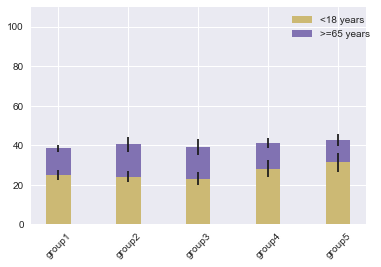

In [454]:
#stacked percentage plot with standard deviation

import numpy as np
import matplotlib.pyplot as plt

N=len(groups_to_plot)

under_18_means=np.empty(N)
under_18_std=np.empty(N)
fr18to65_means=np.empty(N)
fr18to65_std=np.empty(N)
above_65_means=np.empty(N)
above_65_std=np.empty(N)


groups=[1,11,15,2,8]

for n, group in enumerate(groups):
    df_group=df[df['group']==group]
    df_group['adult']=100-df_group['var65']-df_group['var66']
    
    under_18_means[n]=np.mean(df_group['var66'])
    under_18_std[n]=np.std(df_group['var66'])
    
    fr18to65_means[n]=np.mean(df_group['adult'])
    fr18to65_std[n]=np.std(df_group['adult'])
    
    above_65_means[n]=np.mean(df_group['var65'])
    above_65_std[n]=np.std(df_group['var65'])

width = 0.35       # the width of the bars: can also be len(x) sequence

ind = np.arange(N)

p1=plt.bar(ind, under_18_means, width, color='y', yerr=under_18_std)
#p2=plt.bar(ind, fr18to65_means, width, color='r', bottom=under_18_means, yerr=fr18to65_std)
p2=plt.bar(ind, above_65_means, width, color='m', bottom=sum([under_18_means]), yerr=above_65_std)


plt.legend((p1[0], p2[0],p3[0]), ('<18 years', '>=65 years'), bbox_to_anchor=(1.04,1))
plt.xticks(range(N), ['group'+str(i) for i in range(1,N+1)], rotation=45)
plt.ylim(0, 110)
plt.show()

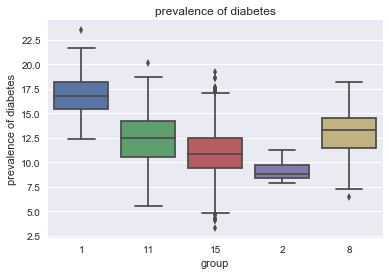

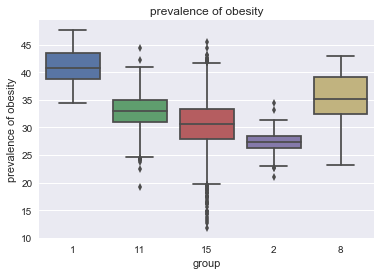

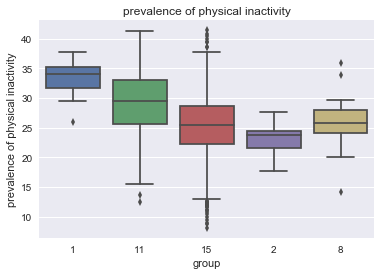

In [525]:
features=['prevalence of diabetes','prevalence of obesity','prevalence of physical inactivity']
data=df[df['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=[1,11,15,2,8])


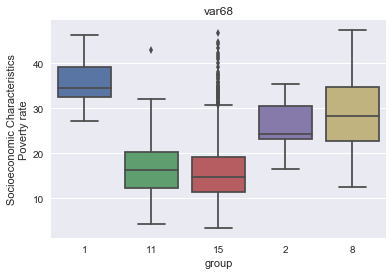

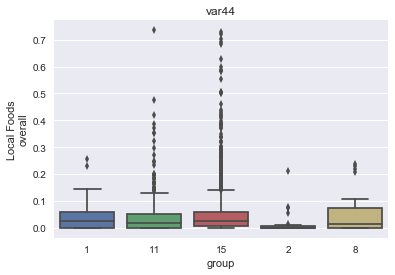

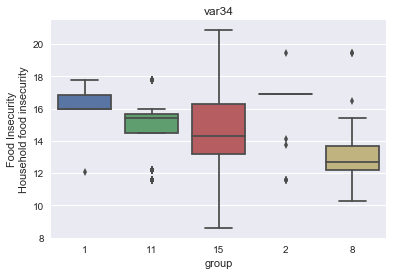

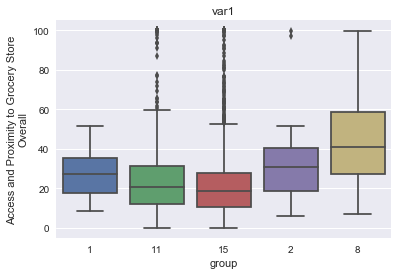

In [526]:
features=['var'+str(n) for n in [68,44,34,1]]
data=df[df['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=[1,11,15,2,8])

In [446]:
data=df[df['group'].isin(groups_to_plot)]
data[['group']].to_csv('C:/Users/cathy/Capstone_project_1/Datasets/cluster_groups.csv')

In [447]:
data[['group']]

group
FIPS        
1001      11
1003      11
1005      11
1007      11
1009      11
1011       1
1013      11
1015      11
1017      11
1019      11
1021      11
1023      11
1025      11
1027      11
1029      11
1031      11
1033      11
1035      11
1037      11
1039      11
1041      11
1043      11
1045      11
1047       1
1049      11
1051      11
1053      11
1055      11
1057      11
1059      11
...      ...
55129     15
55131     15
55133     15
55135     15
55137     15
55139     15
55141     15
56001     15
56003     15
56005     15
56007     15
56009     15
56011     15
56013     15
56015     15
56017     15
56019     15
56021     15
56023     15
56025     15
56027     15
56029     15
56031     15
56033     15
56035     15
56037     15
56039     15
56041     15
56043     15
56045     15

[3109 rows x 1 columns]

In [ ]:
features=['var'+str(n) for n in [68,44,34,1]]
data=df[df['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=[1,11,15,2,8])

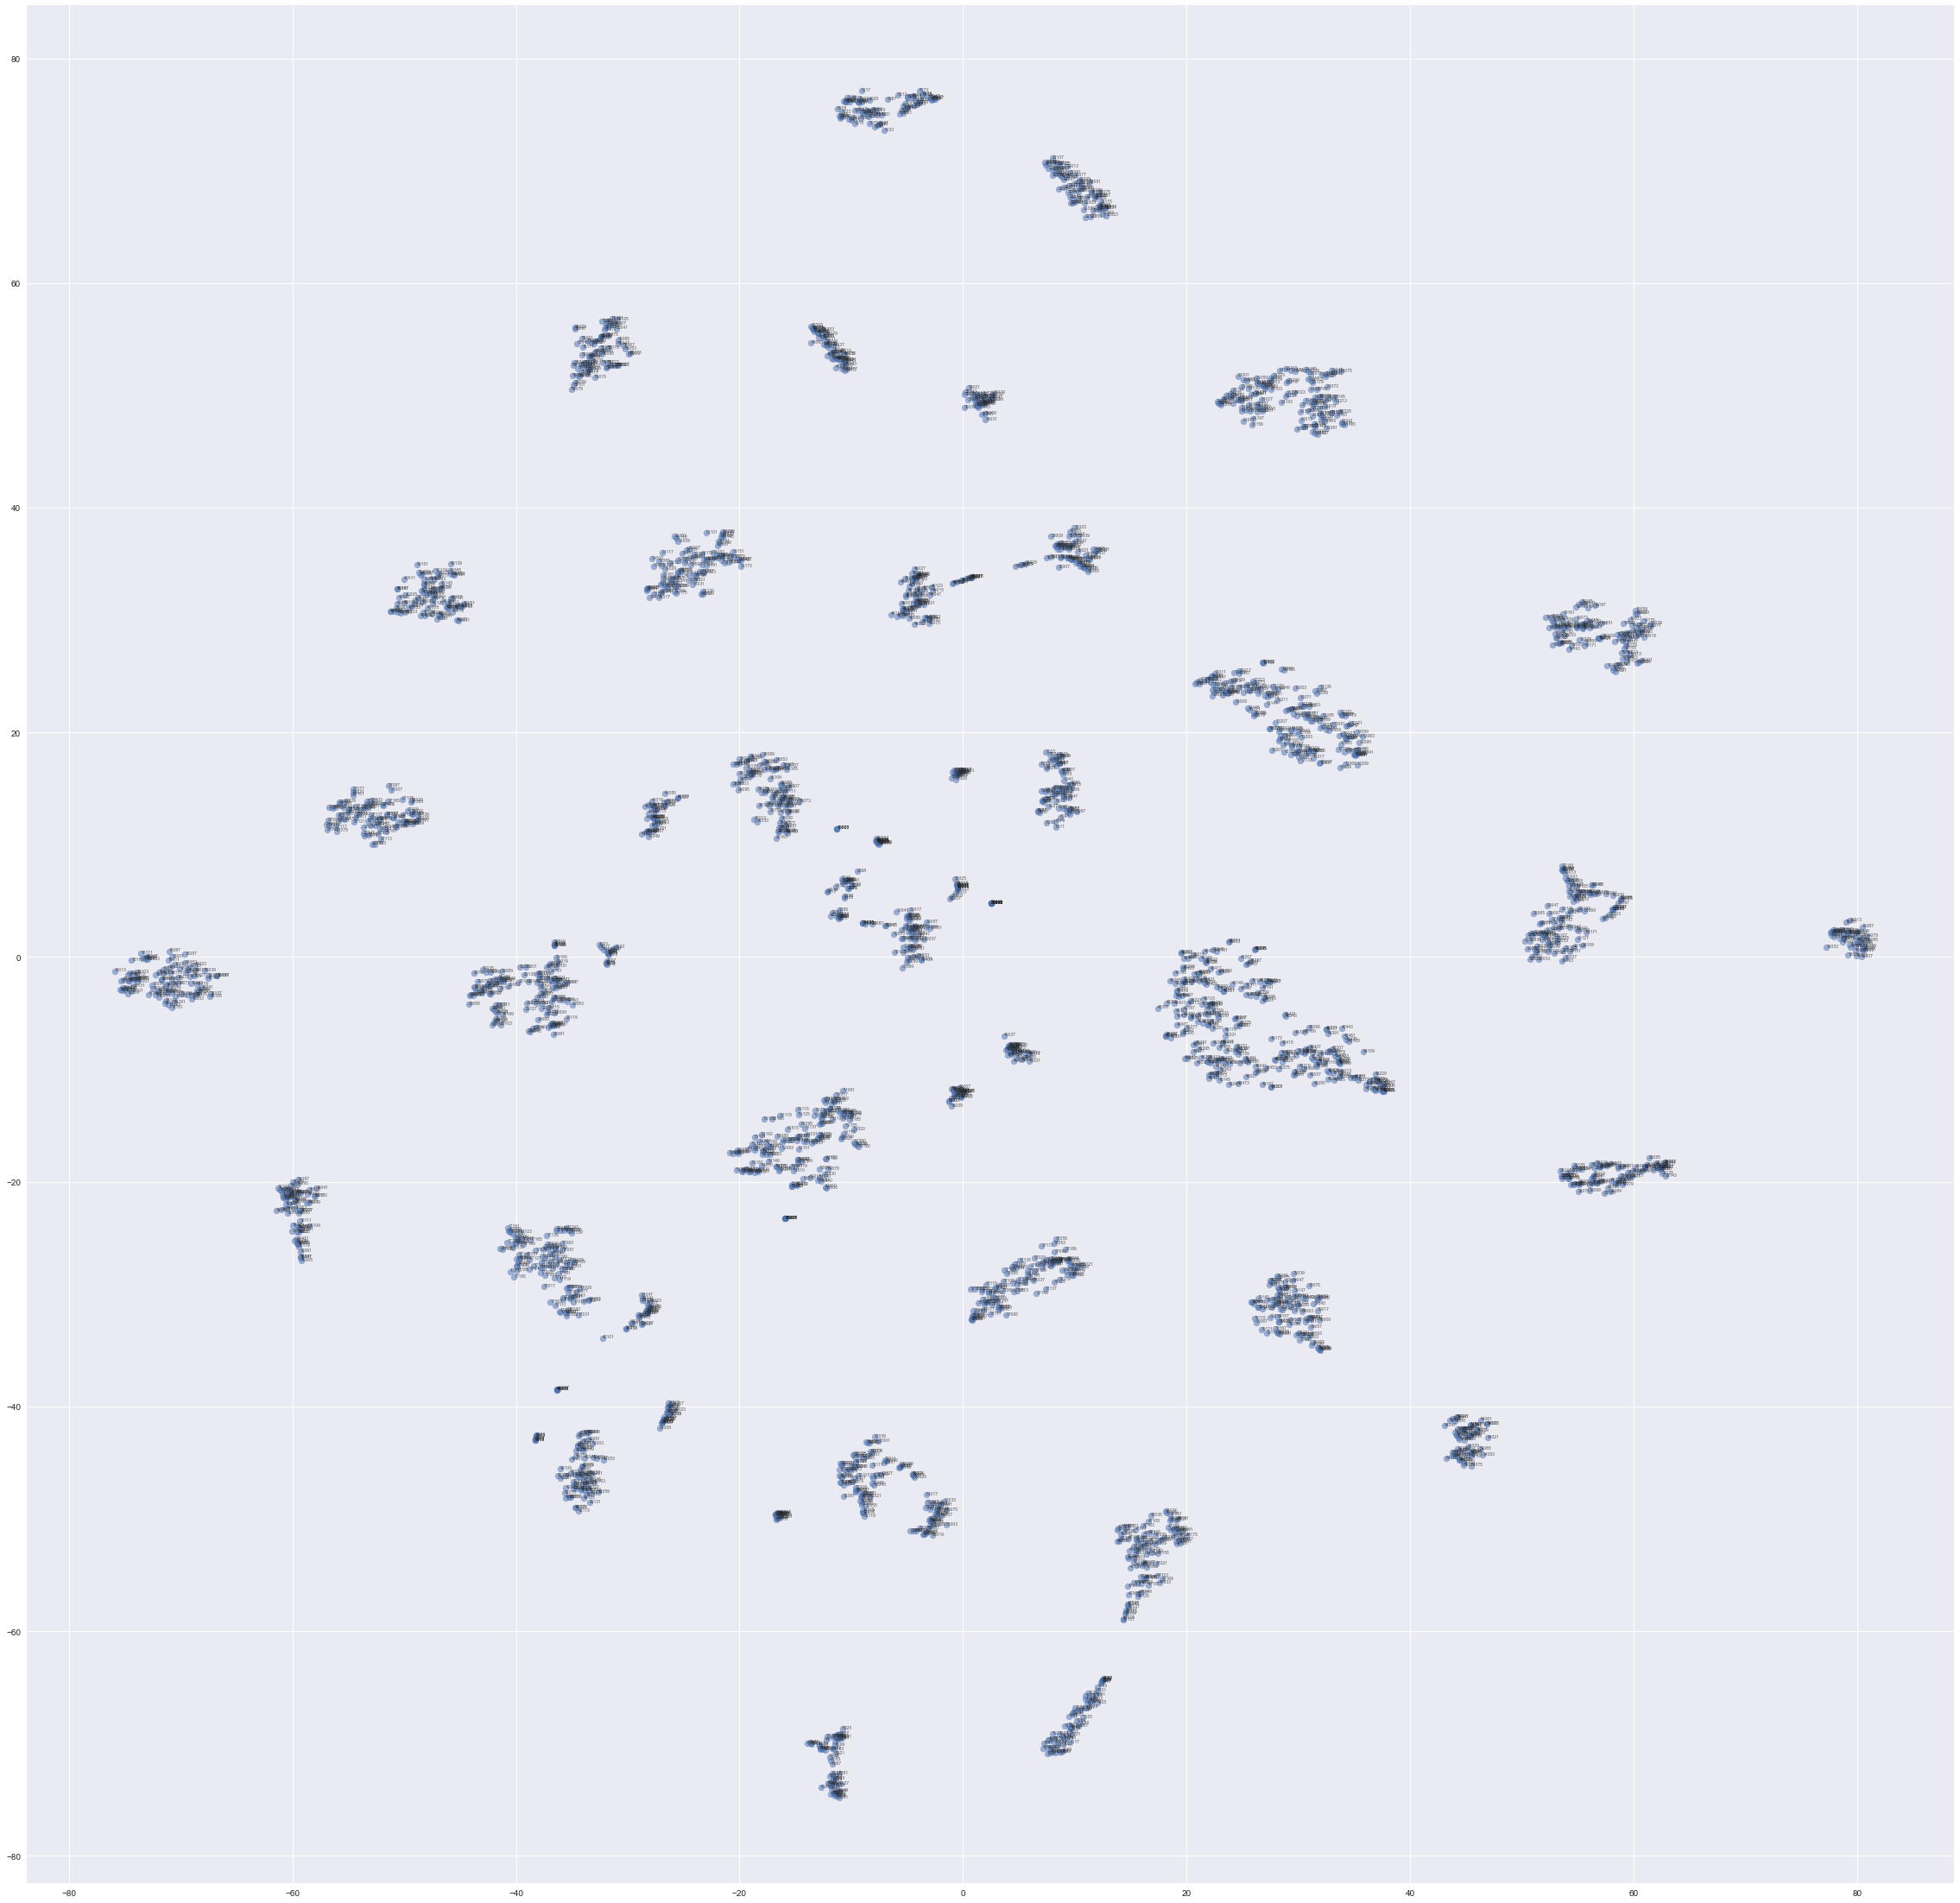

In [361]:
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate=200)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(normed_df[normed_df.columns.difference(['group'])])

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
plt.figure(figsize=(40,40))
plt.scatter(xs, ys, alpha=0.5)
# Scatter plot


# Annotate the points
for x, y, fips in zip(xs, ys, normed_df.index):
    plt.annotate(fips, (x, y), fontsize=5, alpha=0.75)
plt.show()


Hierachical clustering of the most diabetes prevalent counties

In [582]:
df['db_level']=pd.qcut(df['prevalence of diabetes'],6, labels=range(6))
df['ob_level']=pd.qcut(df['prevalence of obesity'],6, labels=range(6))
df['phy_level']=pd.qcut(df['prevalence of physical inactivity'],6, labels=range(6))

In [583]:
df['db_level']

FIPS
1001     4
1003     2
1005     5
1007     5
1009     5
1011     5
1013     5
1015     5
1017     5
1019     4
1021     4
1023     5
1025     5
1027     5
1029     4
1031     5
1033     5
1035     5
1037     5
1039     5
1041     5
1043     5
1045     5
1047     5
1049     4
1051     4
1053     5
1055     5
1057     5
1059     5
        ..
55129    2
55131    0
55133    0
55135    1
55137    2
55139    0
55141    0
56001    0
56003    3
56005    0
56007    0
56009    2
56011    0
56013    1
56015    1
56017    2
56019    0
56021    1
56023    0
56025    1
56027    0
56029    0
56031    0
56033    1
56035    0
56037    0
56039    0
56041    1
56043    3
56045    1
Name: db_level, Length: 3143, dtype: category
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

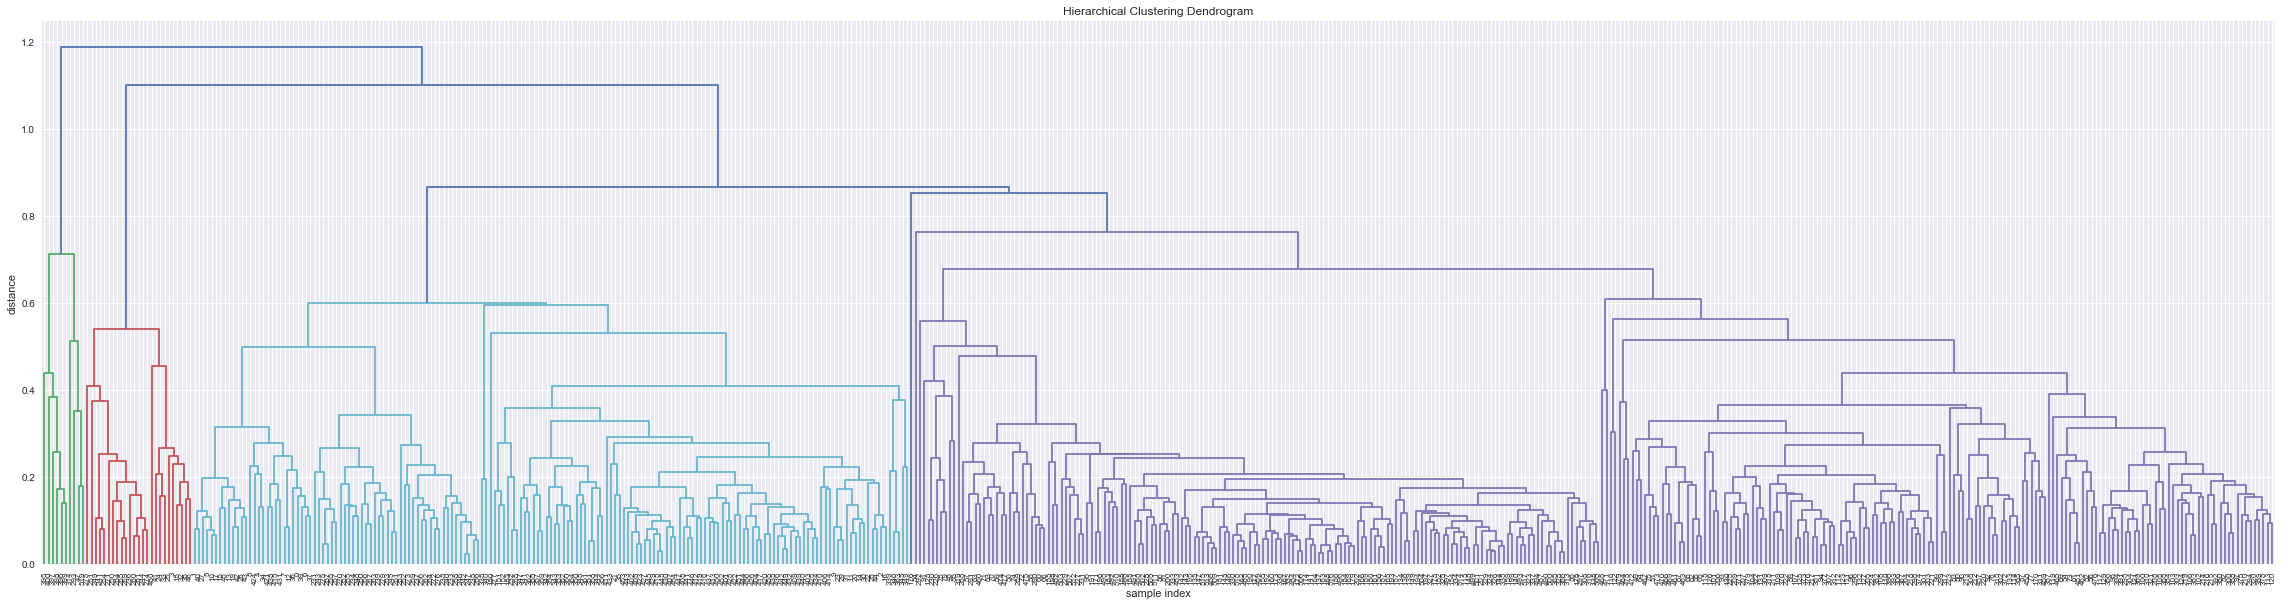

In [584]:
X=df_transformed[df['db_level']==5]
distance_way= ['ward', 'single', 'average', 'weighted', 'centroid', 'median']

Z = linkage(X, 'average')
plt.figure(figsize=(40, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.show()

In [606]:
labels = fcluster(Z,0.9,'distance')
Counter(labels)

Counter({1: 10, 2: 25, 3: 485})

In [620]:
groups_to_plot=[l for l in Counter(labels).keys() if Counter(labels)[l]>=10]

In [621]:
groups_to_plot

[3, 2, 1]

In [622]:
df_subset=df[df['db_level']==5]

In [623]:
df_subset['group']=labels

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [508]:
df_subset[df_subset['group'].isin(groups_to_plot)]['group'].to_csv('C:/Users/cathy/Capstone_project_1/Datasets/Counties_clusters_top_diabetes_prevalence.csv')

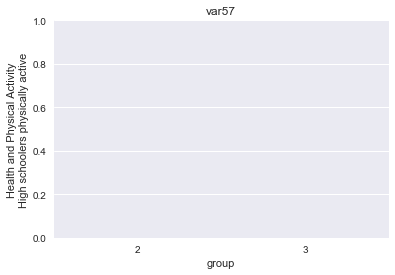

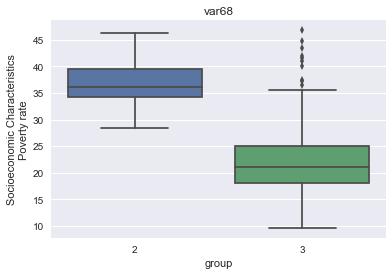

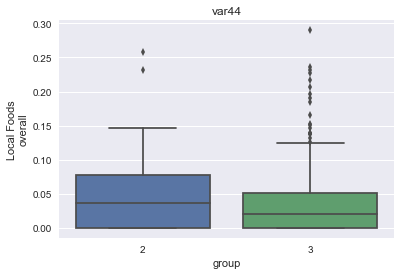

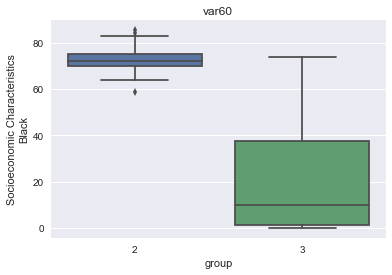

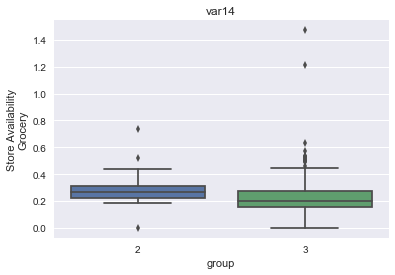

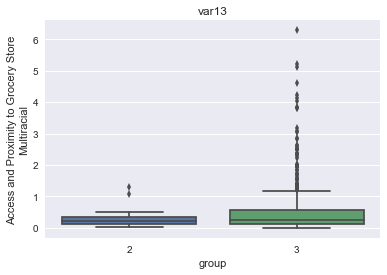

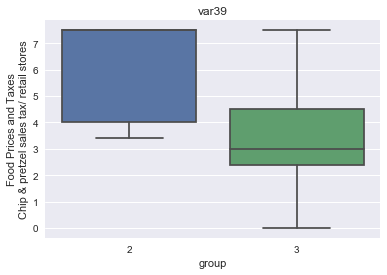

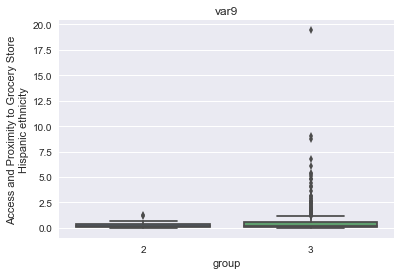

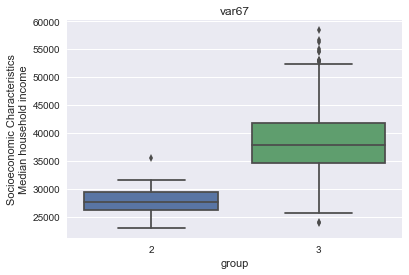

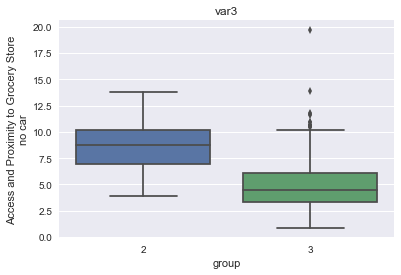

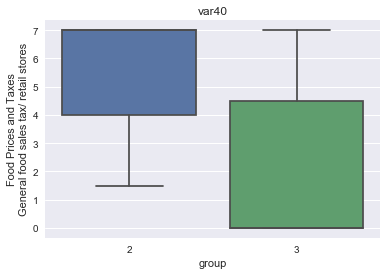

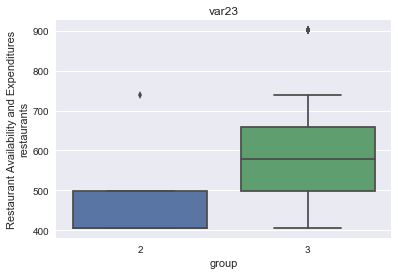

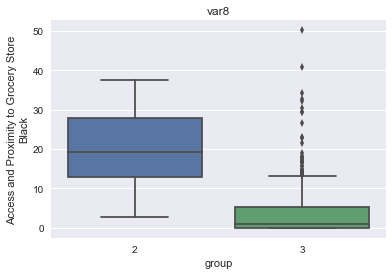

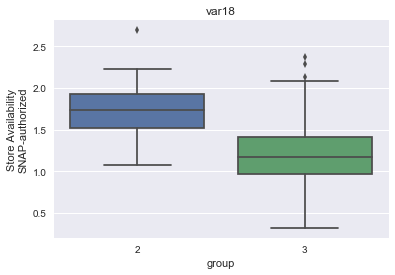

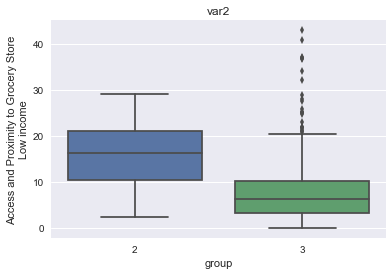

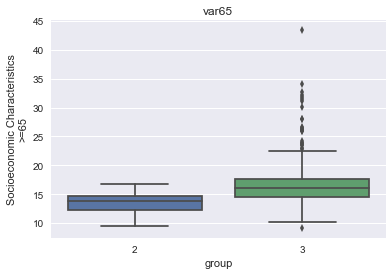

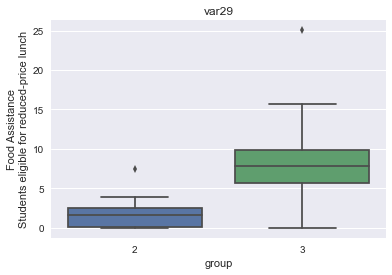

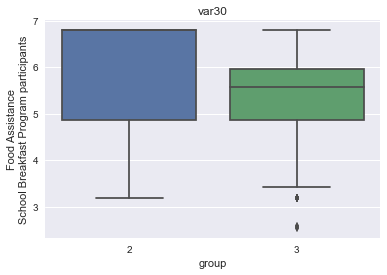

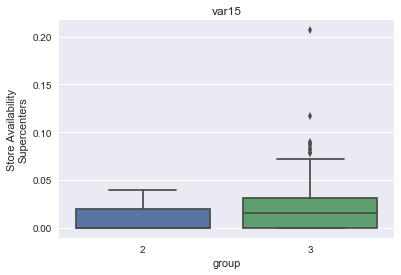

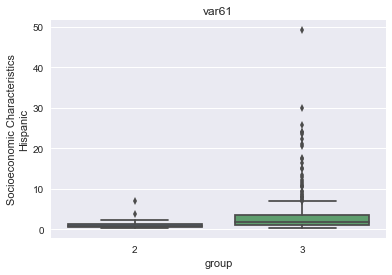

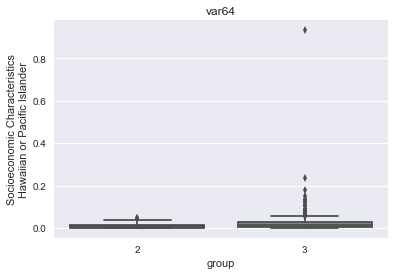

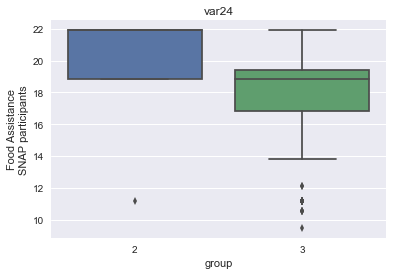

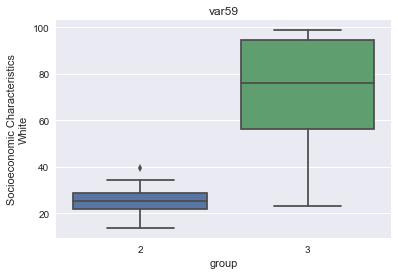

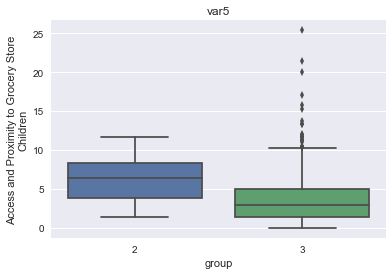

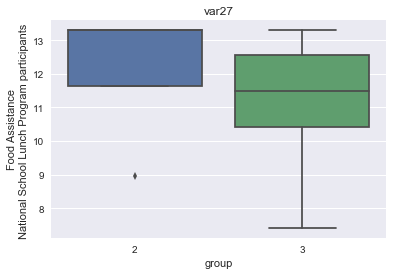

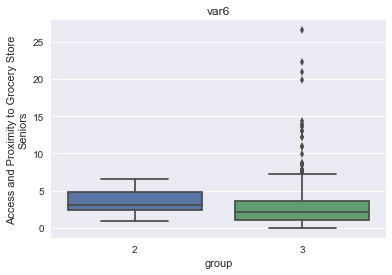

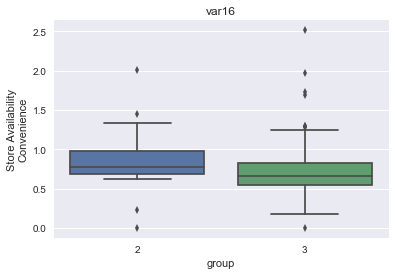

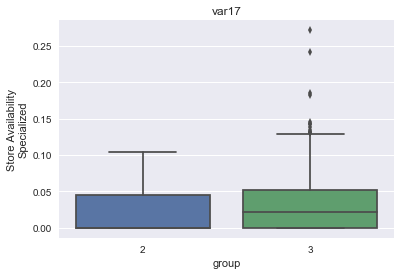

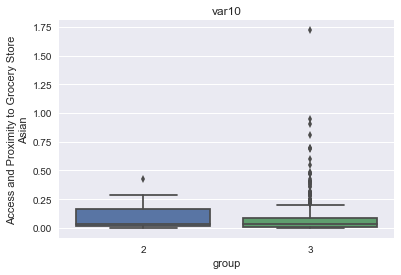

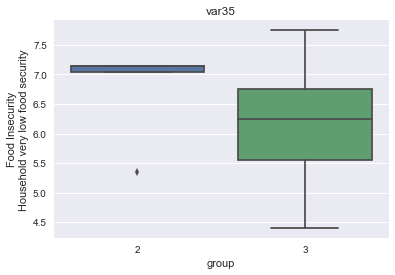

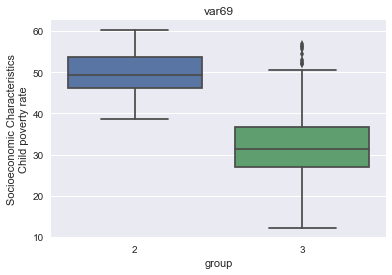

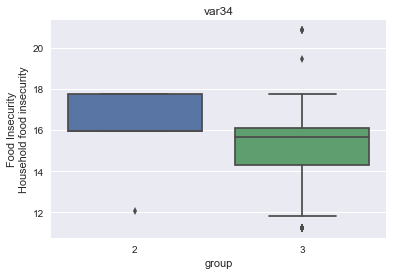

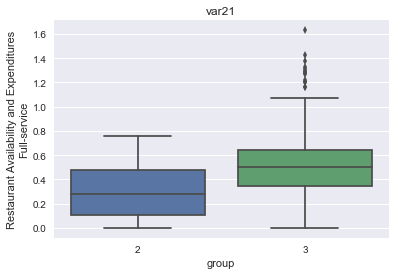

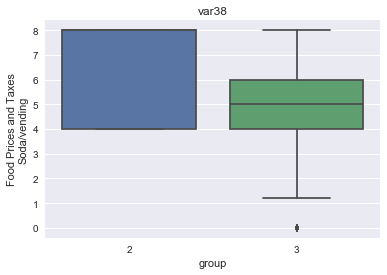

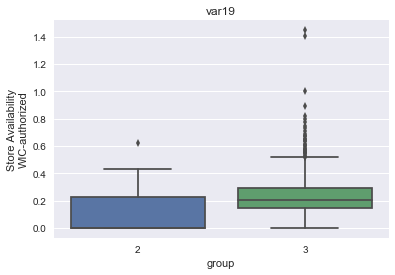

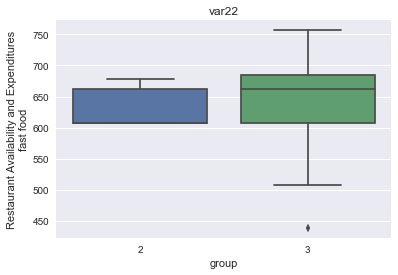

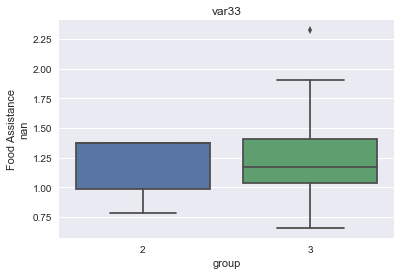

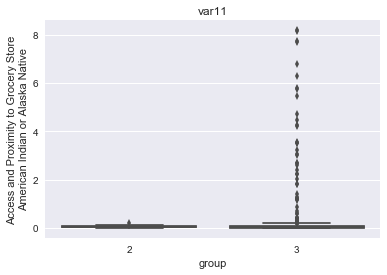

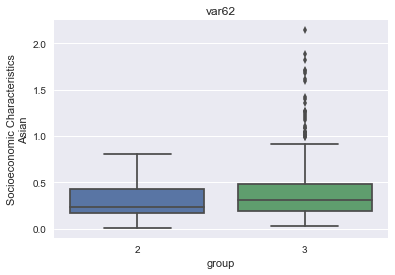

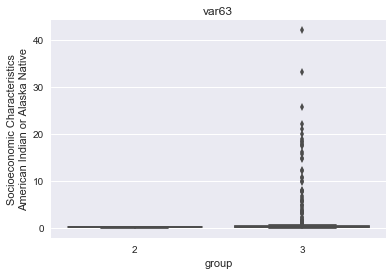

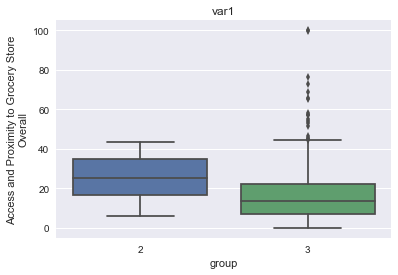

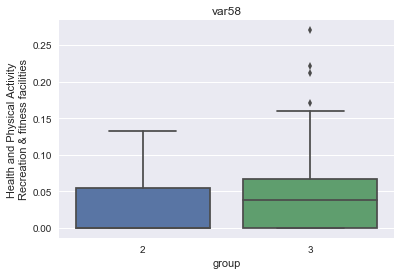

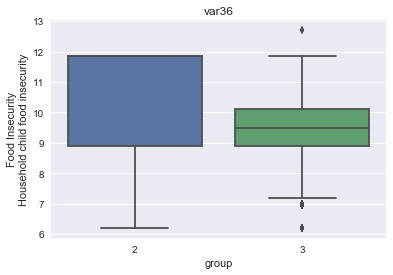

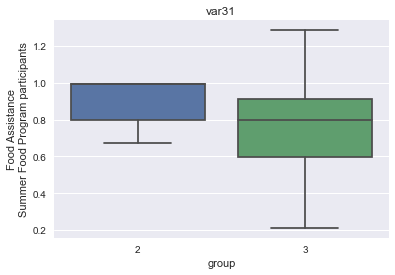

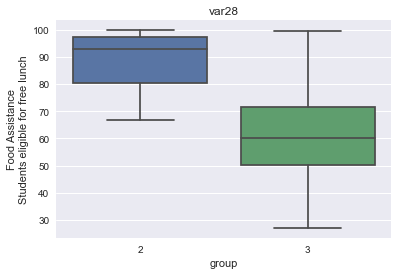

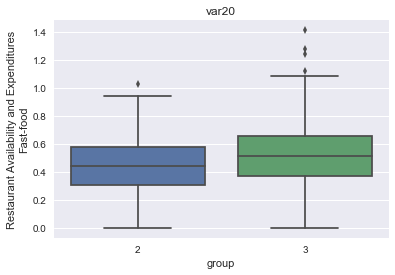

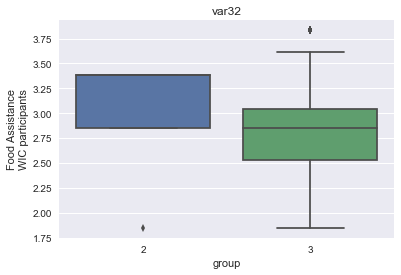

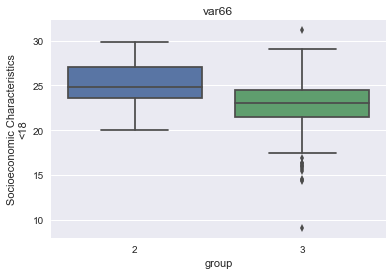

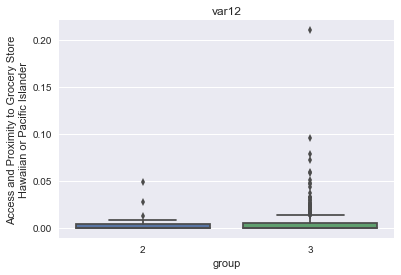

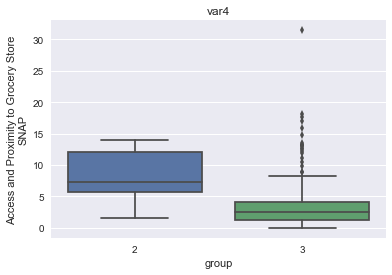

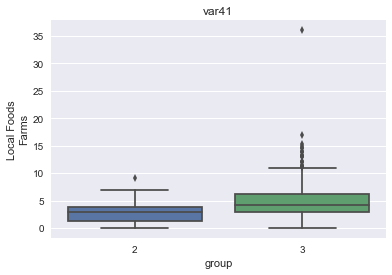

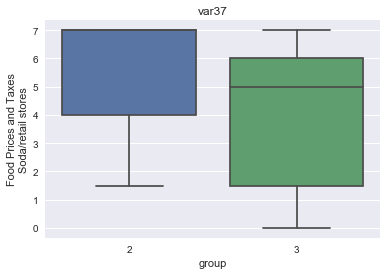

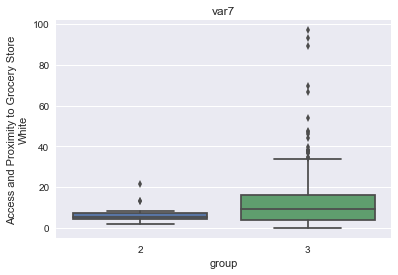

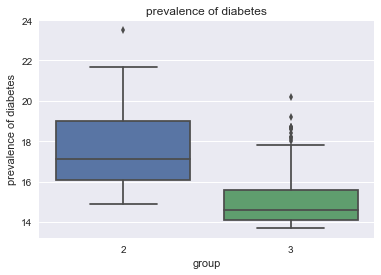

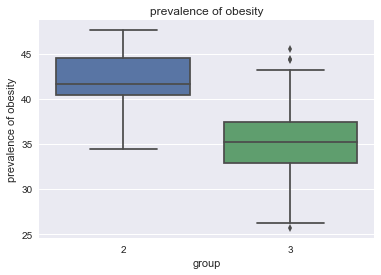

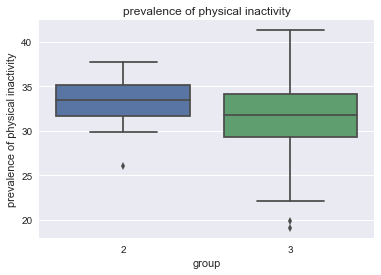

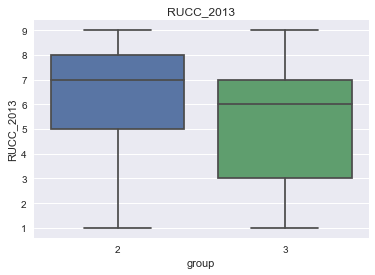

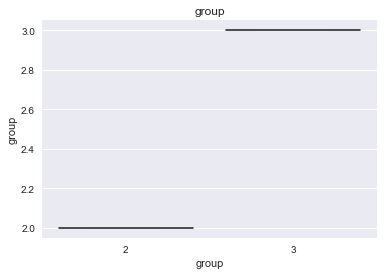

In [612]:
features=df.columns
data=df_subset[df_subset['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=None)

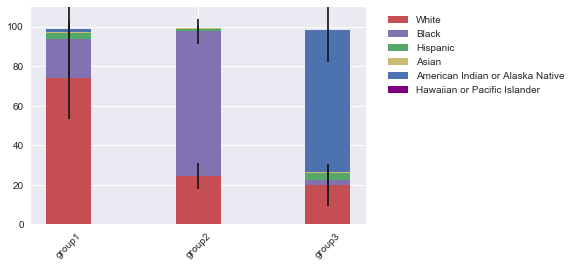

In [624]:
#stacked percentage plot with standard deviation

import numpy as np
import matplotlib.pyplot as plt

N=3


whitemeans=np.empty(N)
whitestd=np.empty(N)
blackmeans=np.empty(N)
blackstd=np.empty(N)
asianmeans=np.empty(N)
asianstd=np.empty(N)
hispmeans=np.empty(N)
hispstd=np.empty(N)
Ame_Ind_Alkmeans=np.empty(N)
Ame_Ind_Alkstd=np.empty(N)
Hawa_Islandmeans=np.empty(N)
Hawa_Islandstd=np.empty(N)

groups=[3,2,1]

for n, group in enumerate(groups):
    df_group=df_subset[df_subset['group']==group]
    whitemeans[n]=np.mean(df_group['var59'])
    whitestd[n]=np.std(df_group['var59'])
    
    blackmeans[n]=np.mean(df_group['var60'])
    blackstd[n]=np.std(df_group['var60'])
    
    asianmeans[n]=np.mean(df_group['var62'])
    asianstd[n]=np.std(df_group['var62'])
    
    hispmeans[n]=np.mean(df_group['var61'])
    hispstd[n]=np.std(df_group['var61'])
    
    Ame_Ind_Alkmeans[n]=np.mean(df_group['var63'])
    Ame_Ind_Alkstd[n]=np.std(df_group['var63'])
    
    Hawa_Islandmeans[n]=np.mean(df_group['var64'])
    Hawa_Islandstd[n]=np.std(df_group['var64'])

width = 0.35       # the width of the bars: can also be len(x) sequence

ind = np.arange(N)

p1=plt.bar(ind, whitemeans, width, color='r', yerr=whitestd)
p2=plt.bar(ind, blackmeans, width, color='m', bottom=whitemeans, yerr=blackstd)
p3=plt.bar(ind, hispmeans, width, color='g', bottom=sum([whitemeans,blackmeans]), yerr=hispstd)
p4=plt.bar(ind, asianmeans, width, color='y', bottom=sum([whitemeans, blackmeans, hispmeans]), yerr=asianstd)
p5=plt.bar(ind, Ame_Ind_Alkmeans, width, color='b', bottom=sum([whitemeans, blackmeans, hispmeans, asianmeans]), yerr=Ame_Ind_Alkstd)
p6=plt.bar(ind, Hawa_Islandmeans, width, color='purple', 
        bottom=np.sum([whitemeans,blackmeans,hispmeans,asianmeans,Ame_Ind_Alkmeans]), yerr=Hawa_Islandstd)

plt.legend((p1[0], p2[0],p3[0], p4[0],p5[0], p6[0]), ('White', 'Black', 
                                                      'Hispanic', 'Asian','American Indian or Alaska Native', 
                                                      'Hawaiian or Pacific Islander'), bbox_to_anchor=(1.04,1))
plt.xticks(range(N), ['group'+str(i) for i in range(1,N+1)], rotation=45)
plt.ylim(0, 110)
plt.show()

C:\anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


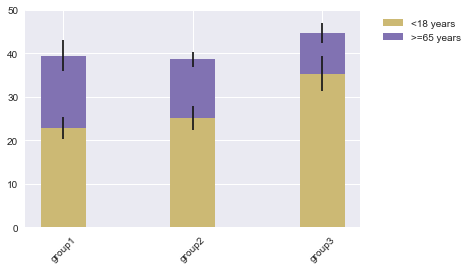

In [625]:
import numpy as np
import matplotlib.pyplot as plt

N=len(groups_to_plot)

under_18_means=np.empty(N)
under_18_std=np.empty(N)
fr18to65_means=np.empty(N)
fr18to65_std=np.empty(N)
above_65_means=np.empty(N)
above_65_std=np.empty(N)


groups=[3,2,1]

for n, group in enumerate(groups):
    df_group=df_subset[df_subset['group']==group]
    df_group['adult']=100-df_group['var65']-df_group['var66']
    
    under_18_means[n]=np.mean(df_group['var66'])
    under_18_std[n]=np.std(df_group['var66'])
    
    fr18to65_means[n]=np.mean(df_group['adult'])
    fr18to65_std[n]=np.std(df_group['adult'])
    
    above_65_means[n]=np.mean(df_group['var65'])
    above_65_std[n]=np.std(df_group['var65'])

width = 0.35       # the width of the bars: can also be len(x) sequence

ind = np.arange(N)

p1=plt.bar(ind, under_18_means, width, color='y', yerr=under_18_std)
#p2=plt.bar(ind, fr18to65_means, width, color='r', bottom=under_18_means, yerr=fr18to65_std)
p2=plt.bar(ind, above_65_means, width, color='m', bottom=sum([under_18_means]), yerr=above_65_std)


plt.legend((p1[0], p2[0],p3[0]), ('<18 years', '>=65 years'), bbox_to_anchor=(1.04,1))
plt.xticks(range(N), ['group'+str(i) for i in range(1,N+1)], rotation=45)
plt.ylim(0, 50)
plt.show()

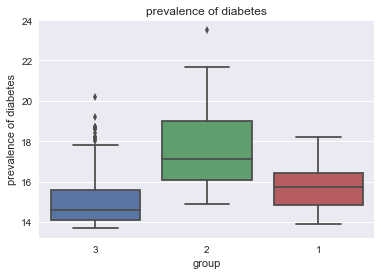

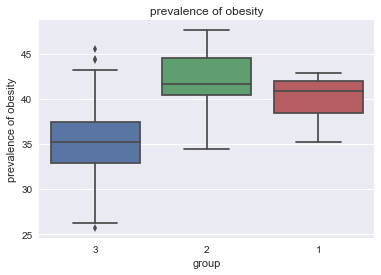

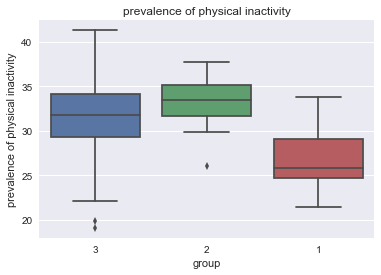

In [626]:
features=['prevalence of diabetes','prevalence of obesity','prevalence of physical inactivity']
data=df_subset[df_subset['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=[3,2,1])

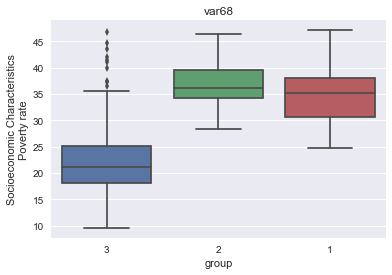

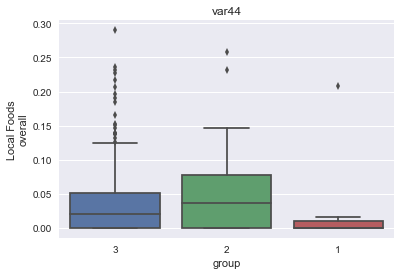

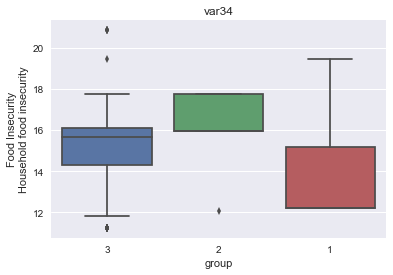

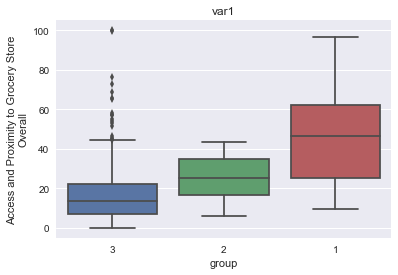

In [627]:
features=['var'+str(n) for n in [68,44,34,1]]
data=df_subset[df_subset['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=[3,2,1])

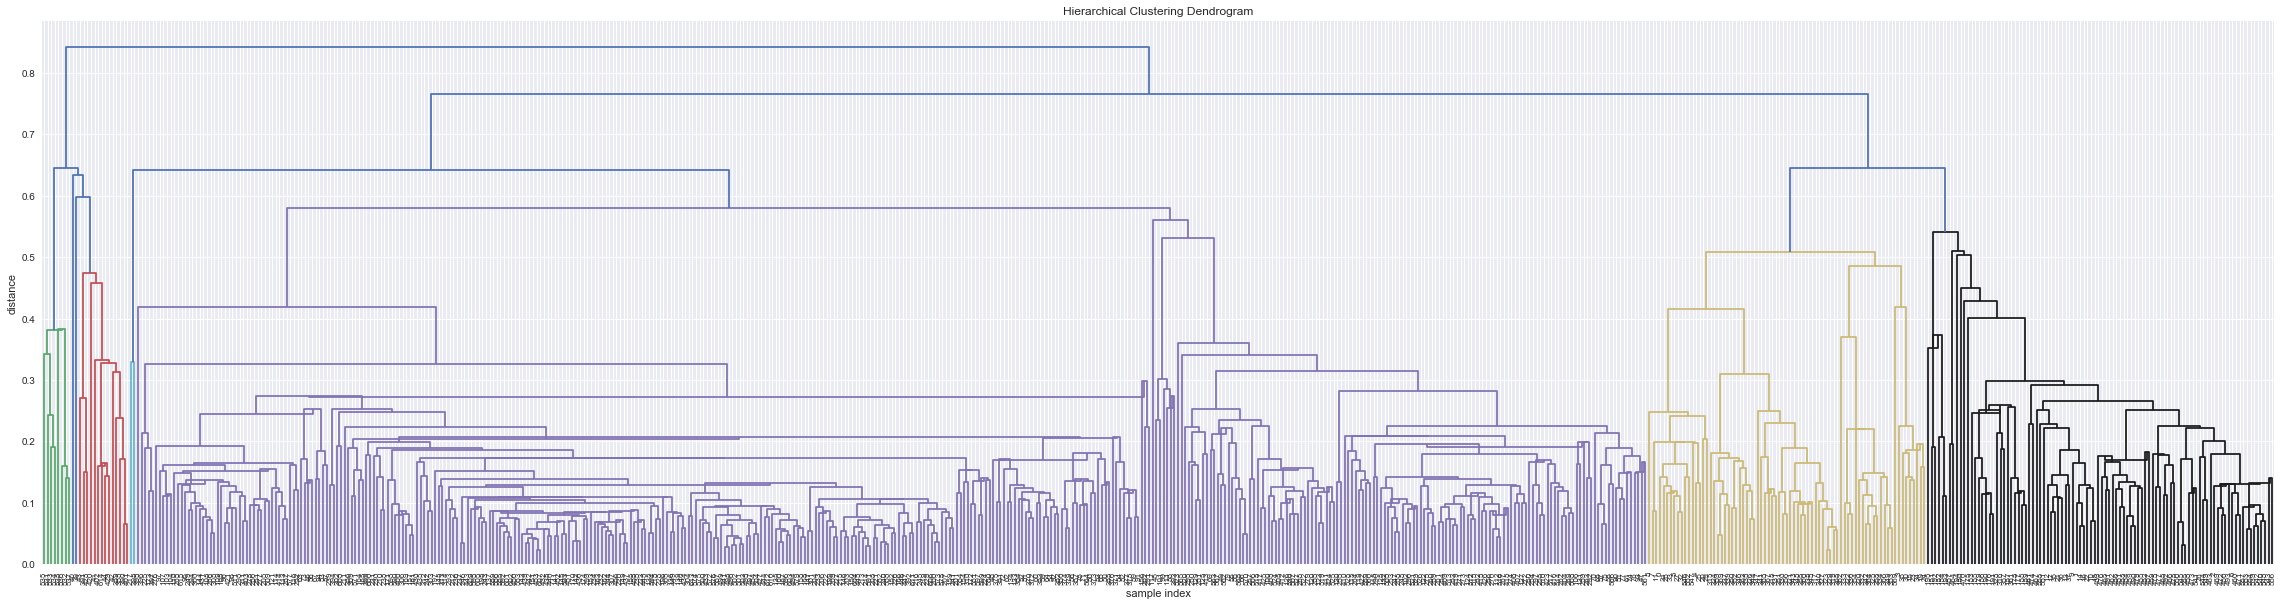

In [509]:
X=df_transformed[df['ob_level']=='>80%']
distance_way= ['ward', 'single', 'average', 'weighted', 'centroid', 'median']

Z = linkage(X, 'centroid')
plt.figure(figsize=(40, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.show()

In [510]:
labels = fcluster(Z,0.58,'distance')
Counter(labels)

Counter({1: 8, 2: 14, 3: 1, 4: 1, 5: 2, 6: 280, 7: 137, 8: 77, 9: 96})

In [511]:
groups_to_plot=[l for l in Counter(labels).keys() if Counter(labels)[l]>15]

In [512]:
groups_to_plot

[8, 9, 7, 6]

In [513]:
df_subset=df[df['ob_level']=='>80%']

In [514]:
df_subset['group']=labels

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [515]:
df_subset[df_subset['group'].isin(groups_to_plot)]['group'].to_csv('C:/Users/cathy/Capstone_project_1/Datasets/Counties_clusters_top_obesity_prevalence.csv')

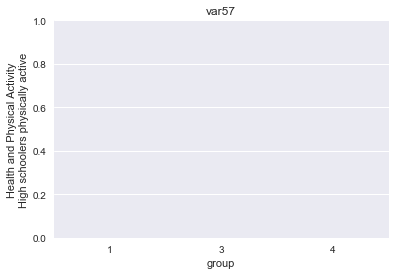

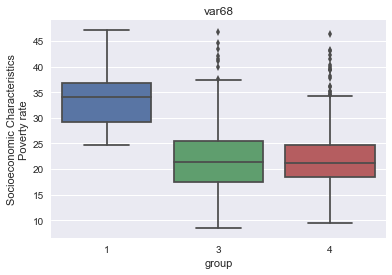

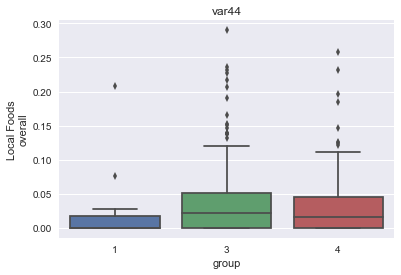

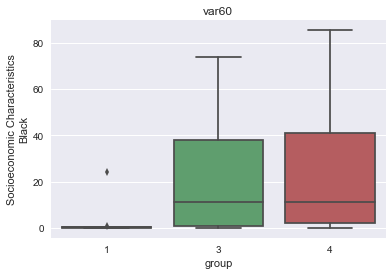

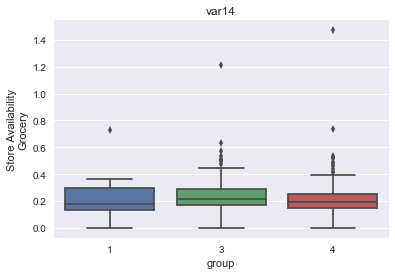

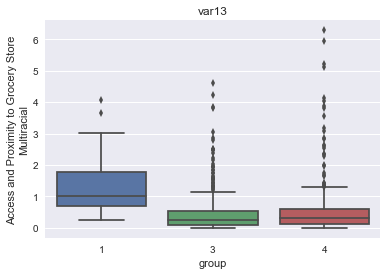

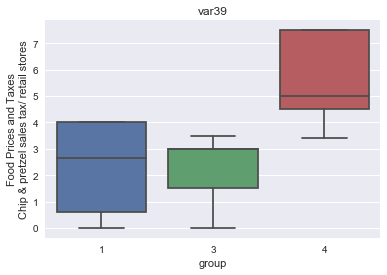

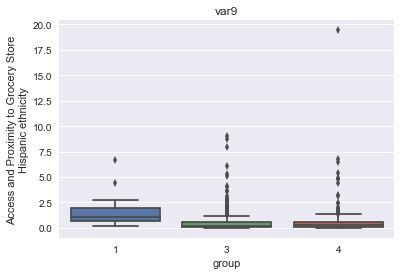

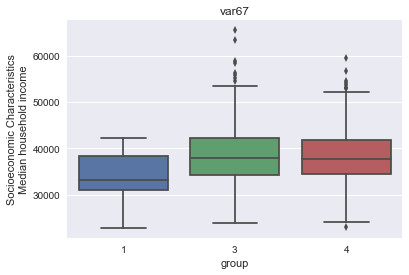

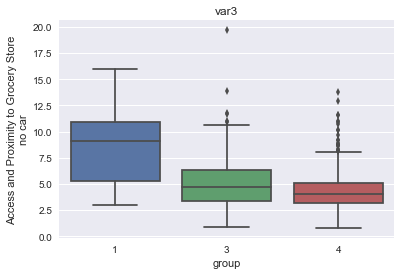

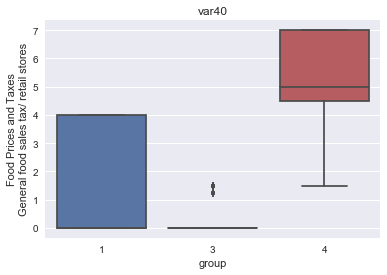

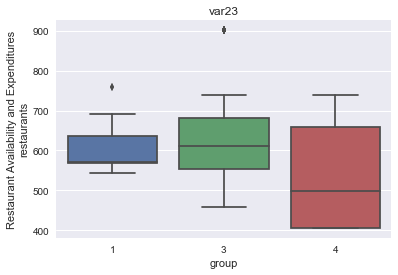

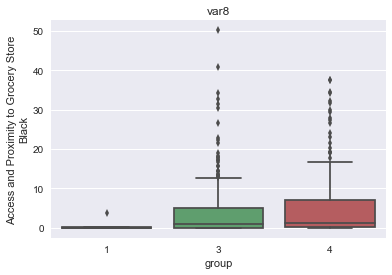

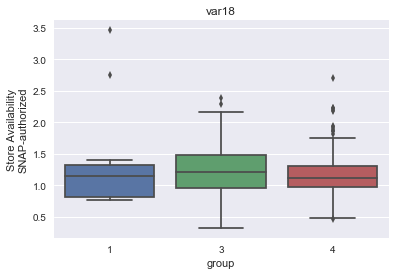

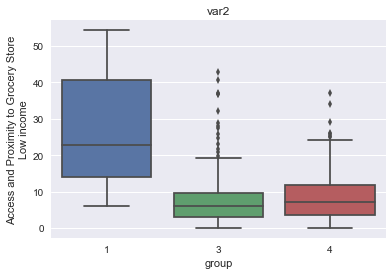

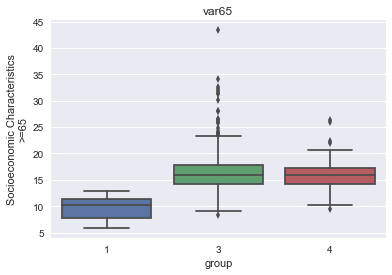

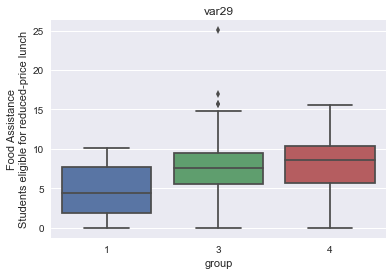

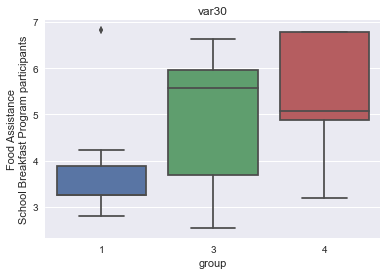

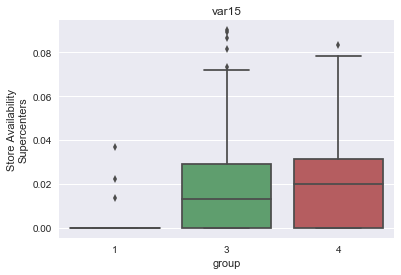

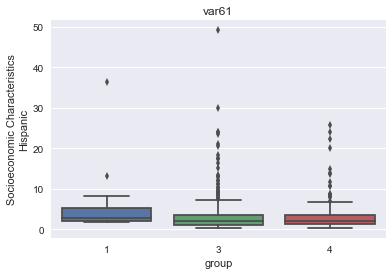

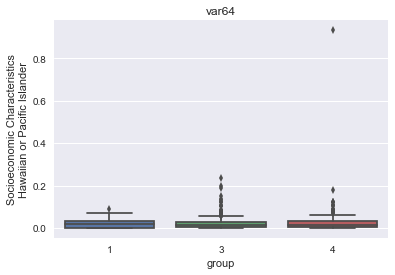

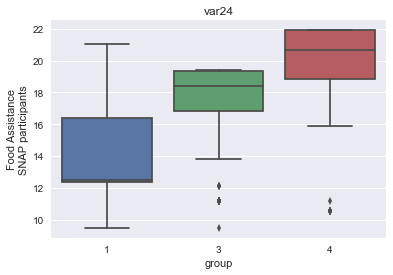

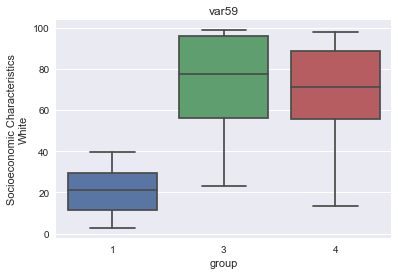

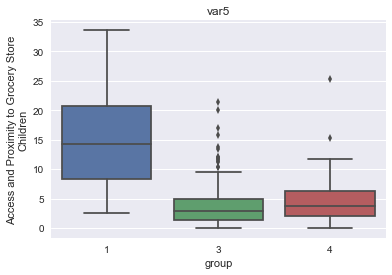

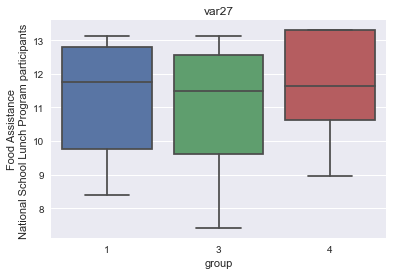

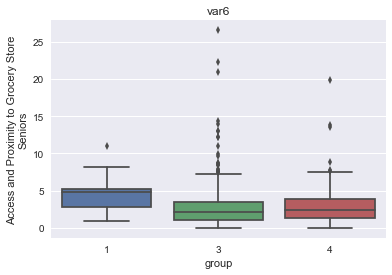

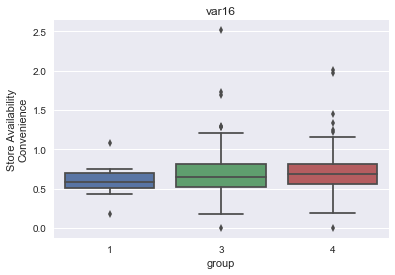

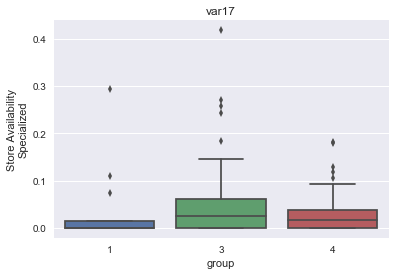

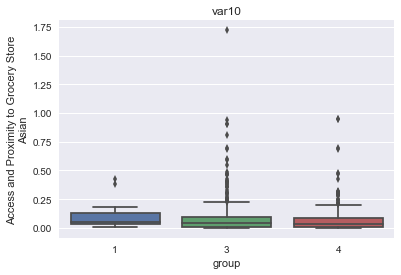

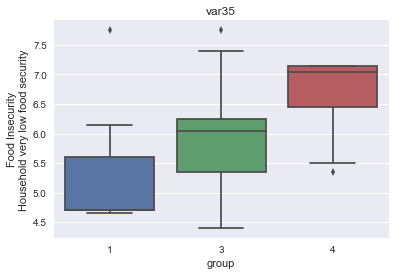

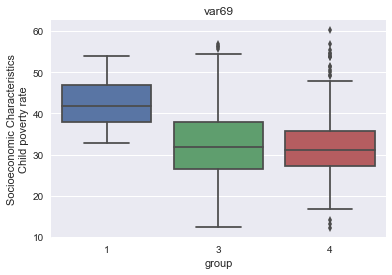

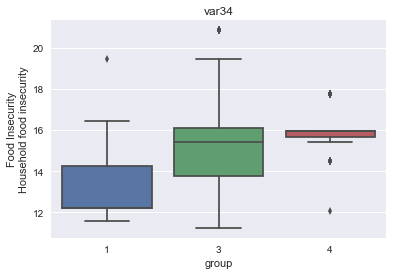

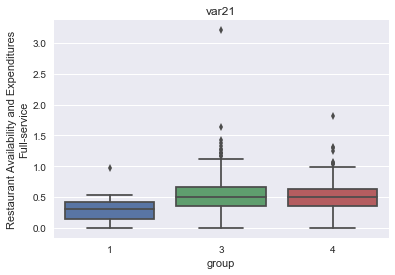

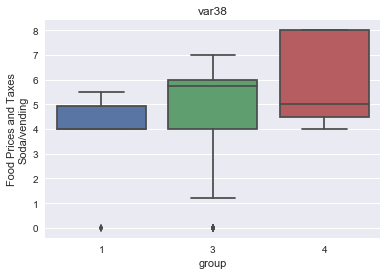

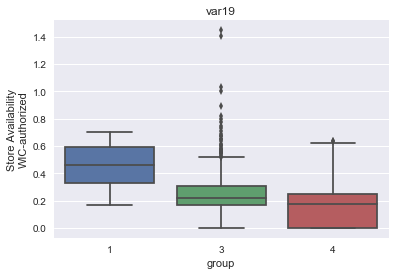

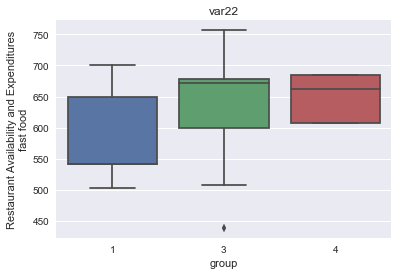

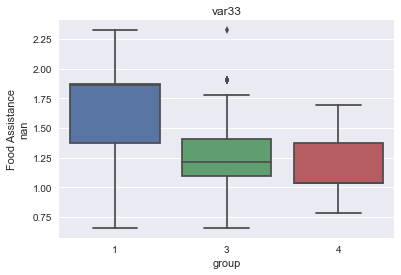

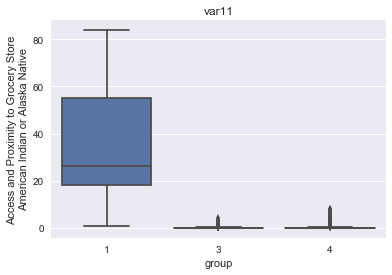

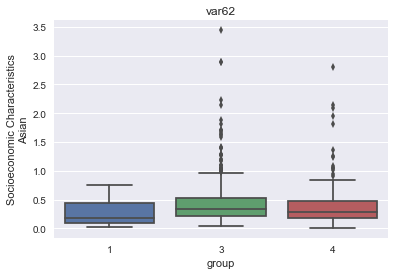

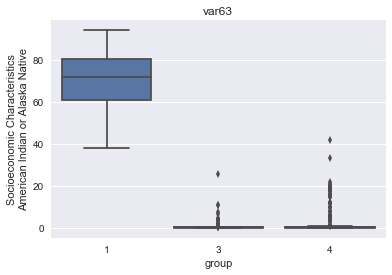

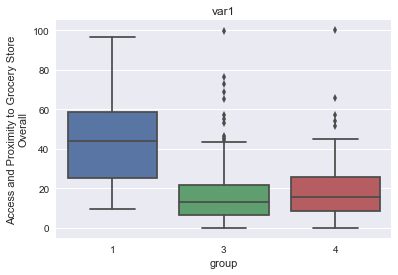

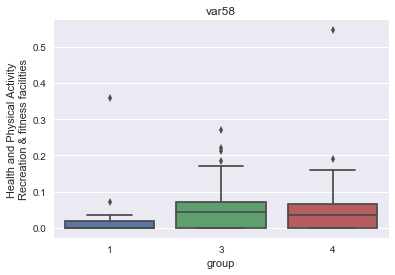

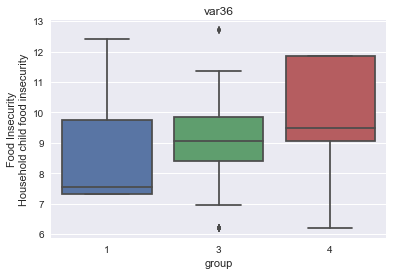

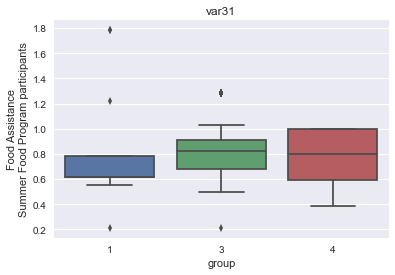

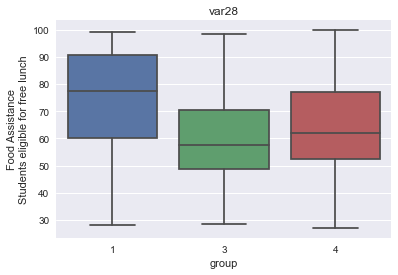

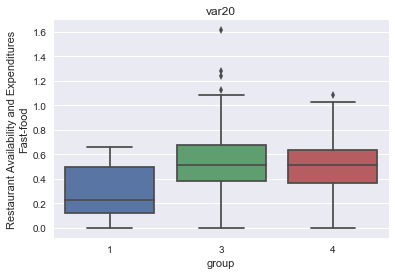

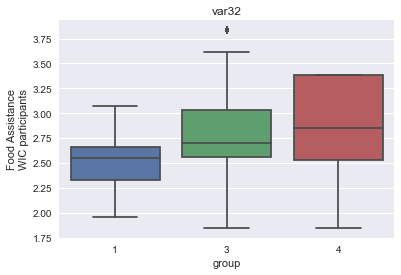

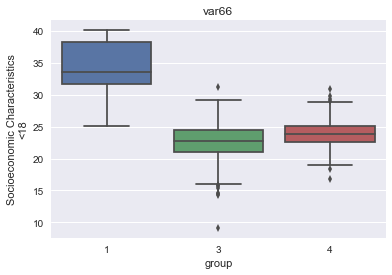

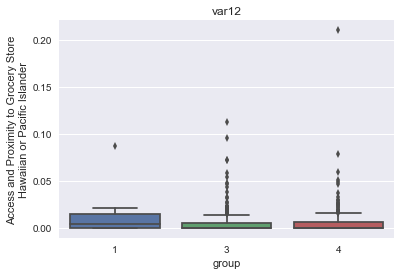

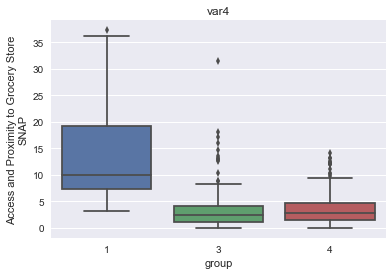

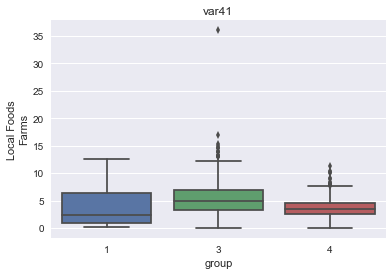

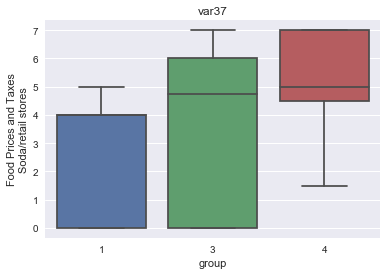

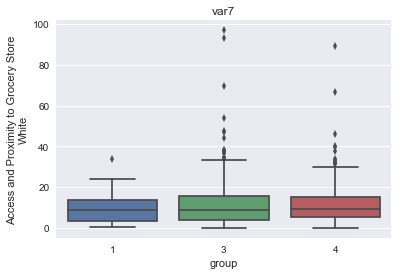

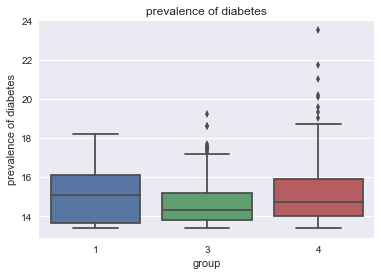

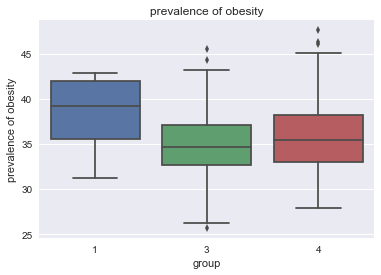

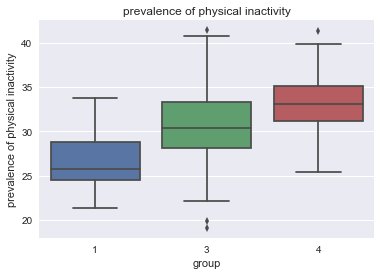

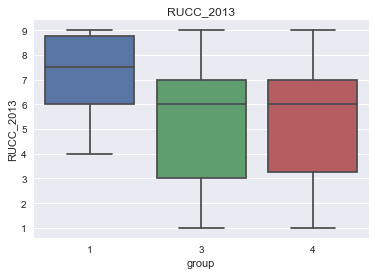

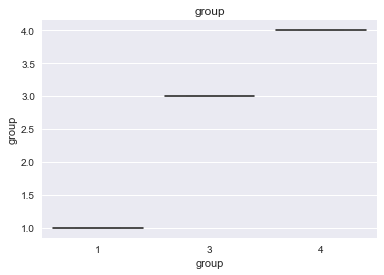

In [466]:
features=df.columns
data=df_subset[df_subset['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=None)

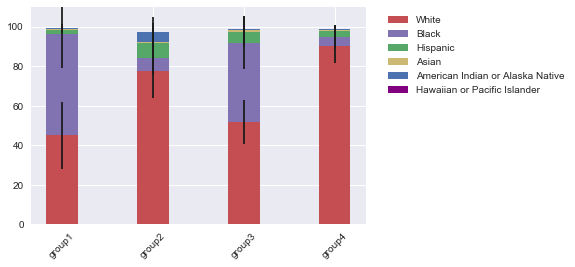

In [484]:
#stacked percentage plot with standard deviation

import numpy as np
import matplotlib.pyplot as plt

N=4


whitemeans=np.empty(N)
whitestd=np.empty(N)
blackmeans=np.empty(N)
blackstd=np.empty(N)
asianmeans=np.empty(N)
asianstd=np.empty(N)
hispmeans=np.empty(N)
hispstd=np.empty(N)
Ame_Ind_Alkmeans=np.empty(N)
Ame_Ind_Alkstd=np.empty(N)
Hawa_Islandmeans=np.empty(N)
Hawa_Islandstd=np.empty(N)

groups=[8, 9, 7, 6]

for n, group in enumerate(groups):
    df_group=df_subset[df_subset['group']==group]
    whitemeans[n]=np.mean(df_group['var59'])
    whitestd[n]=np.std(df_group['var59'])
    
    blackmeans[n]=np.mean(df_group['var60'])
    blackstd[n]=np.std(df_group['var60'])
    
    asianmeans[n]=np.mean(df_group['var62'])
    asianstd[n]=np.std(df_group['var62'])
    
    hispmeans[n]=np.mean(df_group['var61'])
    hispstd[n]=np.std(df_group['var61'])
    
    Ame_Ind_Alkmeans[n]=np.mean(df_group['var63'])
    Ame_Ind_Alkstd[n]=np.std(df_group['var63'])
    
    Hawa_Islandmeans[n]=np.mean(df_group['var64'])
    Hawa_Islandstd[n]=np.std(df_group['var64'])

width = 0.35       # the width of the bars: can also be len(x) sequence

ind = np.arange(N)

p1=plt.bar(ind, whitemeans, width, color='r', yerr=whitestd)
p2=plt.bar(ind, blackmeans, width, color='m', bottom=whitemeans, yerr=blackstd)
p3=plt.bar(ind, hispmeans, width, color='g', bottom=sum([whitemeans,blackmeans]), yerr=hispstd)
p4=plt.bar(ind, asianmeans, width, color='y', bottom=sum([whitemeans, blackmeans, hispmeans]), yerr=asianstd)
p5=plt.bar(ind, Ame_Ind_Alkmeans, width, color='b', bottom=sum([whitemeans, blackmeans, hispmeans, asianmeans]), yerr=Ame_Ind_Alkstd)
p6=plt.bar(ind, Hawa_Islandmeans, width, color='purple', 
        bottom=np.sum([whitemeans,blackmeans,hispmeans,asianmeans,Ame_Ind_Alkmeans]), yerr=Hawa_Islandstd)

plt.legend((p1[0], p2[0],p3[0], p4[0],p5[0], p6[0]), ('White', 'Black', 
                                                      'Hispanic', 'Asian','American Indian or Alaska Native', 
                                                      'Hawaiian or Pacific Islander'), bbox_to_anchor=(1.04,1))
plt.xticks(range(N), ['group'+str(i) for i in range(1,N+1)], rotation=45)
plt.ylim(0, 110)
plt.show()

C:\anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


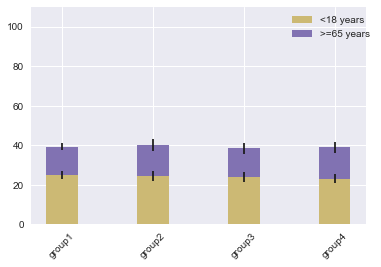

In [485]:
import numpy as np
import matplotlib.pyplot as plt

N=len(groups_to_plot)

under_18_means=np.empty(N)
under_18_std=np.empty(N)
fr18to65_means=np.empty(N)
fr18to65_std=np.empty(N)
above_65_means=np.empty(N)
above_65_std=np.empty(N)


groups=[8, 9, 7, 6]

for n, group in enumerate(groups):
    df_group=df_subset[df_subset['group']==group]
    df_group['adult']=100-df_group['var65']-df_group['var66']
    
    under_18_means[n]=np.mean(df_group['var66'])
    under_18_std[n]=np.std(df_group['var66'])
    
    fr18to65_means[n]=np.mean(df_group['adult'])
    fr18to65_std[n]=np.std(df_group['adult'])
    
    above_65_means[n]=np.mean(df_group['var65'])
    above_65_std[n]=np.std(df_group['var65'])

width = 0.35       # the width of the bars: can also be len(x) sequence

ind = np.arange(N)

p1=plt.bar(ind, under_18_means, width, color='y', yerr=under_18_std)
#p2=plt.bar(ind, fr18to65_means, width, color='r', bottom=under_18_means, yerr=fr18to65_std)
p2=plt.bar(ind, above_65_means, width, color='m', bottom=sum([under_18_means]), yerr=above_65_std)


plt.legend((p1[0], p2[0],p3[0]), ('<18 years', '>=65 years'), bbox_to_anchor=(1.04,1))
plt.xticks(range(N), ['group'+str(i) for i in range(1,N+1)], rotation=45)
plt.ylim(0, 110)
plt.show()

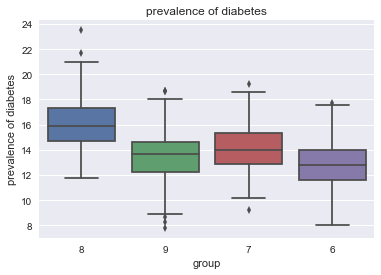

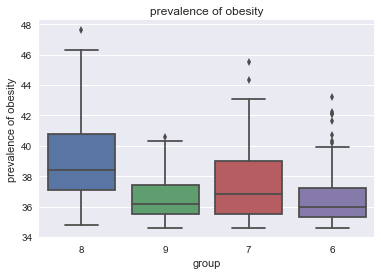

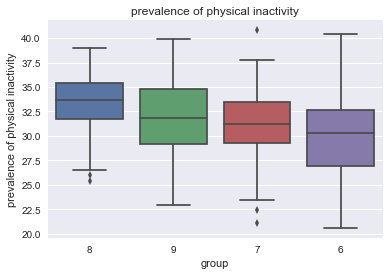

In [486]:
features=['prevalence of diabetes','prevalence of obesity','prevalence of physical inactivity']
data=df_subset[df_subset['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=[8, 9, 7, 6])

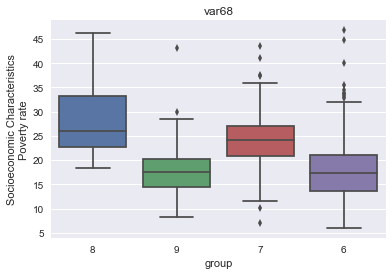

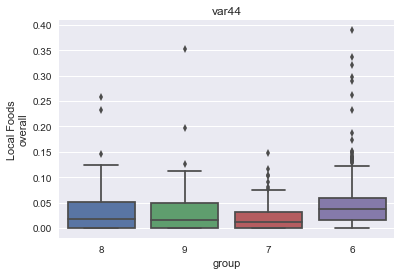

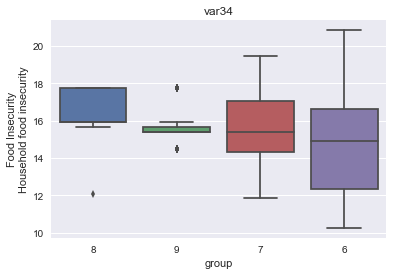

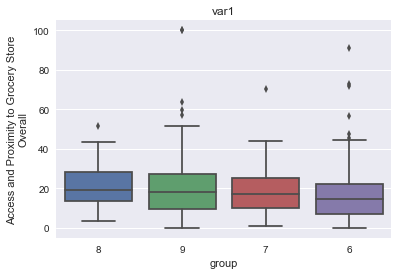

In [487]:
features=['var'+str(n) for n in [68,44,34,1]]
data=df_subset[df_subset['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group', order=[8, 9, 7, 6])